In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sarima-and-lstm/kaggle-EGF.xlsx


In [3]:
import pandas as pd  # Data manipulation
import numpy as np  # Numerical operations
import matplotlib.pyplot as plt  # Data visualization
import seaborn as sns  # Statistical data visualization
import tensorflow as tf 
import optuna
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error  # RMSE calculation
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV  # Grid hyperparameter search
import joblib  # Model saving/loading
import warnings 
warnings.filterwarnings("ignore")  # Ignore warnings
from sklearn.model_selection import train_test_split, cross_val_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [4]:
data = pd.read_excel('/kaggle/input/sarima-and-lstm/kaggle-EGF.xlsx')

In [5]:
data.head()

,Date,CPI National Year on Year Inflation,Advances by banks,Auto Sales,Consumer Confidence Index,Call Money Rate (End of Period),IMF Commodity Prices,National Consumer Price Index,Credit to the Private Sector,Deposits of Banks,...,KIBOR 1 Year Interest Rate,KIBOR 6 months Interest Rate,Karachi Stock Exchange All Shares Index,Lending Rate,International Oil Prices,SBP Policy Rate,Public Sector Borrowing,Real Output - Quantum Index of Large-Scale Manufacturing Industries,Real Effective Exchange Rate,Weighted Average Overnight Repo Rate
0,2012-01-01,10.108950,3492649,15722,29.480,10.90,136.29,79.84,3017343.29,5682167,...,11.75,11.65,8225.97,5.88,106.71,12.0,3402132.3,87.502708,104.7421,10.983810
1,2012-02-01,11.156968,3567035,24172,29.935,11.52,140.04,80.80,2973088.24,5716810,...,11.74,11.65,8946.64,5.85,112.71,12.0,3496690.9,87.634954,102.9416,11.652252
2,2012-03-01,10.842391,3606844,23286,30.390,11.27,140.11,81.58,2959743.01,5920093,...,11.81,11.70,9649.95,5.74,117.83,12.0,3534390.5,87.735341,104.0896,11.255238
3,2012-04-01,11.256580,3602125,21337,29.175,11.33,139.73,82.43,2966975.64,5935537,...,11.85,11.75,9812.71,5.76,113.76,12.0,3602892.8,87.883433,105.7597,11.309048
4,2012-05-01,12.290578,3626809,23713,27.960,10.85,134.00,83.78,2924350.78,6021033,...,11.87,11.76,9714.33,5.88,104.34,12.0,3691756.4,88.100621,107.3915,11.110455


In [6]:
data.columns

Index(['Date', 'CPI National Year on Year Inflation', 'Advances by banks',
       'Auto Sales', 'Consumer Confidence Index',
       'Call Money Rate (End of Period)', 'IMF Commodity Prices',
       'National Consumer Price Index', 'Credit to the Private Sector',
       'Deposits of Banks', 'Deposit Rate',
       'Pakistani Rupee to US Dollar Nominal Exchange Rate',
       'Economic Policy Uncertainty', 'Fertilizers Sales',
       'Karachi Stock Exchange 100 Index', 'KIBOR 1 Year Interest Rate',
       'KIBOR 6 months Interest Rate',
       'Karachi Stock Exchange All Shares Index', 'Lending Rate',
       'International Oil Prices', 'SBP Policy Rate',
       'Public Sector Borrowing',
       'Real Output - Quantum Index of Large-Scale Manufacturing Industries',
       'Real Effective Exchange Rate',
       'Weighted Average Overnight Repo Rate '],
      dtype='object')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 25 columns):
 #   Column                                                               Non-Null Count  Dtype         
---  ------                                                               --------------  -----         
 0   Date                                                                 142 non-null    datetime64[ns]
 1   CPI National Year on Year Inflation                                  142 non-null    float64       
 2   Advances by banks                                                    142 non-null    int64         
 3   Auto Sales                                                           142 non-null    int64         
 4   Consumer Confidence Index                                            142 non-null    float64       
 5   Call Money Rate (End of Period)                                      142 non-null    float64       
 6   IMF Commodity Prices                              

In [8]:
# Specifying columns for plotting to avoid redundancy in later plots
columns_to_plot = ['CPI National Year on Year Inflation', 'Advances by banks',
                   'Auto Sales', 'Consumer Confidence Index',
                   'Call Money Rate (End of Period)', 'IMF Commodity Prices',
                   'National Consumer Price Index', 'Credit to the Private Sector',
                   'Deposits of Banks', 'Deposit Rate',
                   'Pakistani Rupee to US Dollar Nominal Exchange Rate',
                   'Economic Policy Uncertainty', 'Fertilizers Sales',
                   'Karachi Stock Exchange 100 Index', 'KIBOR 1 Year Interest Rate',
                   'KIBOR 6 months Interest Rate', 'Karachi Stock Exchange All Shares Index',
                   'Lending Rate', 'International Oil Prices', 'SBP Policy Rate',
                   'Public Sector Borrowing', 'Real Output - Quantum Index of Large-Scale Manufacturing Industries',
                   'Real Effective Exchange Rate', 'Weighted Average Overnight Repo Rate ']

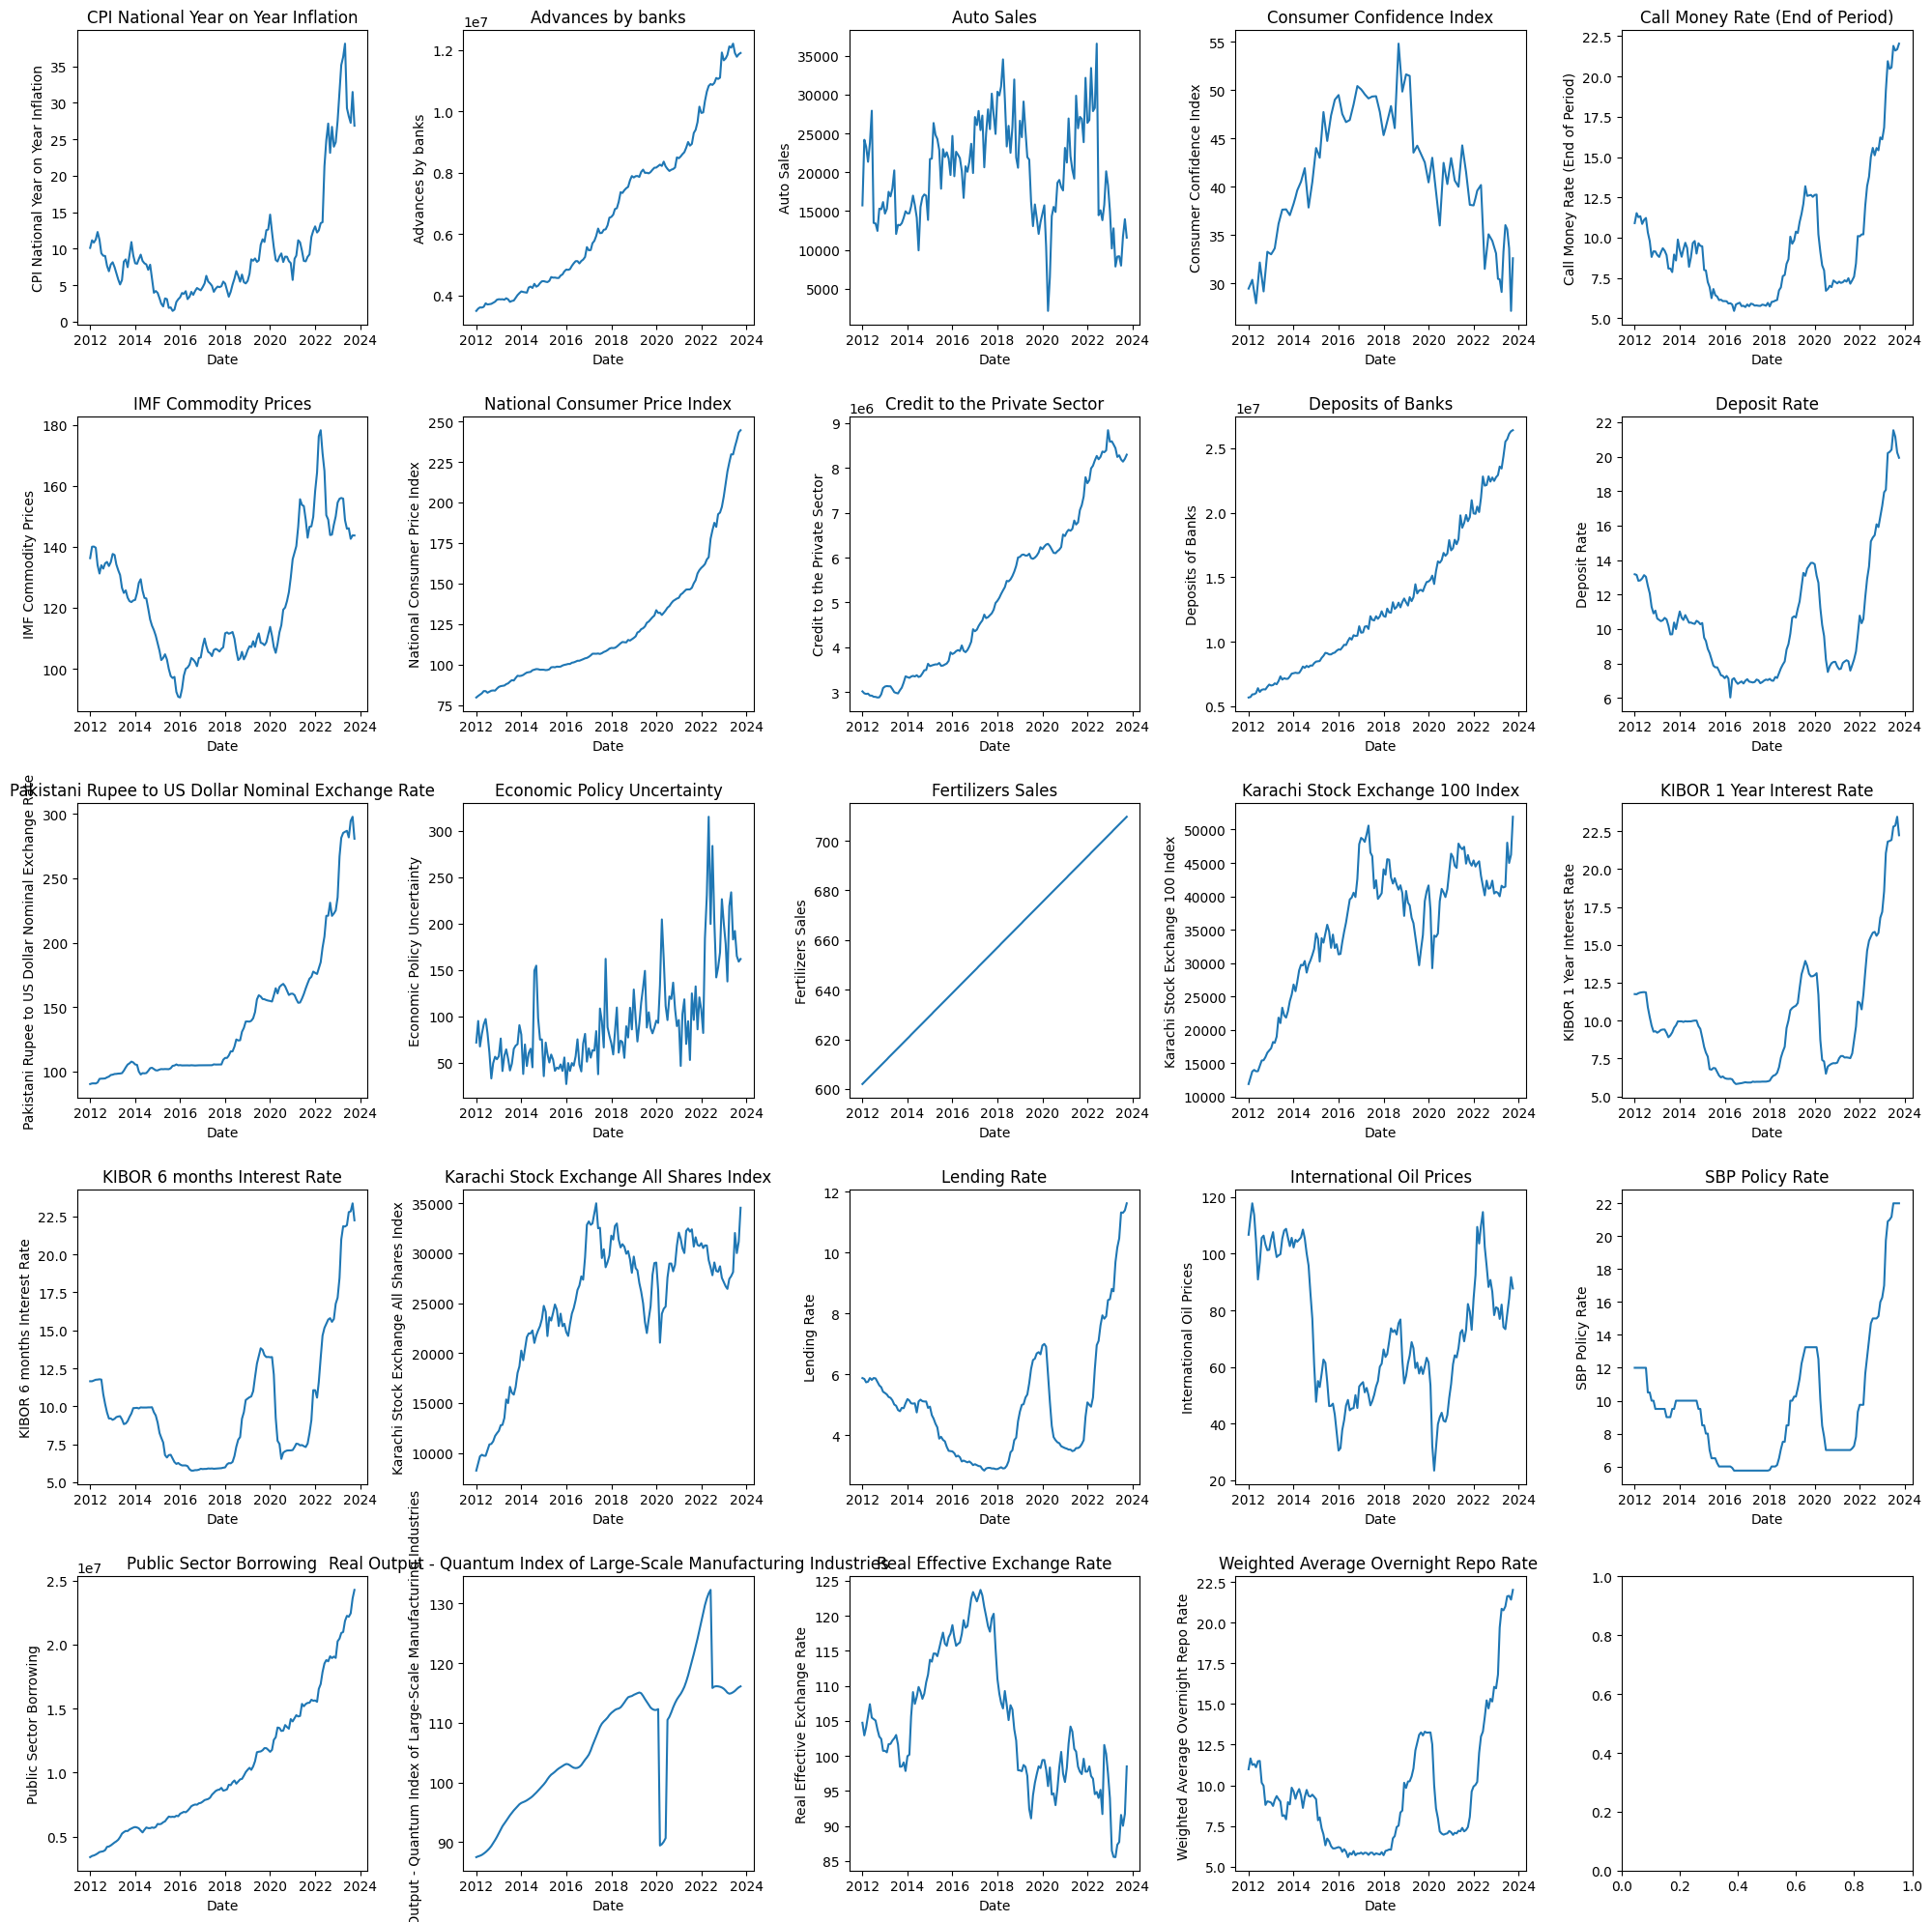

In [9]:
# Subplots for visualizing all columns
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))
axes = axes.flatten()  # Flatten for easy indexing

for i, column in enumerate(columns_to_plot):
    axes[i].plot(data['Date'], data[column])
    axes[i].set_title(column)
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(column)

plt.tight_layout()
plt.savefig('mega_plot.png', bbox_inches='tight', dpi=700)  # Save image
plt.show()

In [10]:
#Robust Scaling
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

scaler_robust = RobustScaler()
data_robust_scaled = scaler_robust.fit_transform(data[numeric_columns])

data_robust_scaled_df = pd.DataFrame(data_robust_scaled, columns=numeric_columns)

date_column = data.iloc[:, 0]  # Extract the Date column

# Combine Date column with scaled data
data_final = pd.concat([date_column, data_robust_scaled_df], axis=1)

data_final.to_csv('data final.csv', index=False)

In [11]:
# Fit the Robust Scaler
scaler_robust = RobustScaler()
scaler_robust.fit(data_final[numeric_columns])

# Extract median and IQR
median = scaler_robust.center_
iqr = scaler_robust.scale_ * 1.349  # IQR is the scale multiplied by 1.349

print(median)
print(iqr)

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.46511014e-16
  0.00000000e+00  0.00000000e+00  1.65666092e-16  1.70002901e-16
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.19479079e-16
 -1.05514555e-15  2.94902991e-16  0.00000000e+00  1.81061763e-16
  0.00000000e+00  1.97975317e-16 -1.63280847e-16  0.00000000e+00
 -1.18394877e-16  4.23272528e-16 -4.69242700e-16  2.06432094e-16]
[1.349 1.349 1.349 1.349 1.349 1.349 1.349 1.349 1.349 1.349 1.349 1.349
 1.349 1.349 1.349 1.349 1.349 1.349 1.349 1.349 1.349 1.349 1.349 1.349]


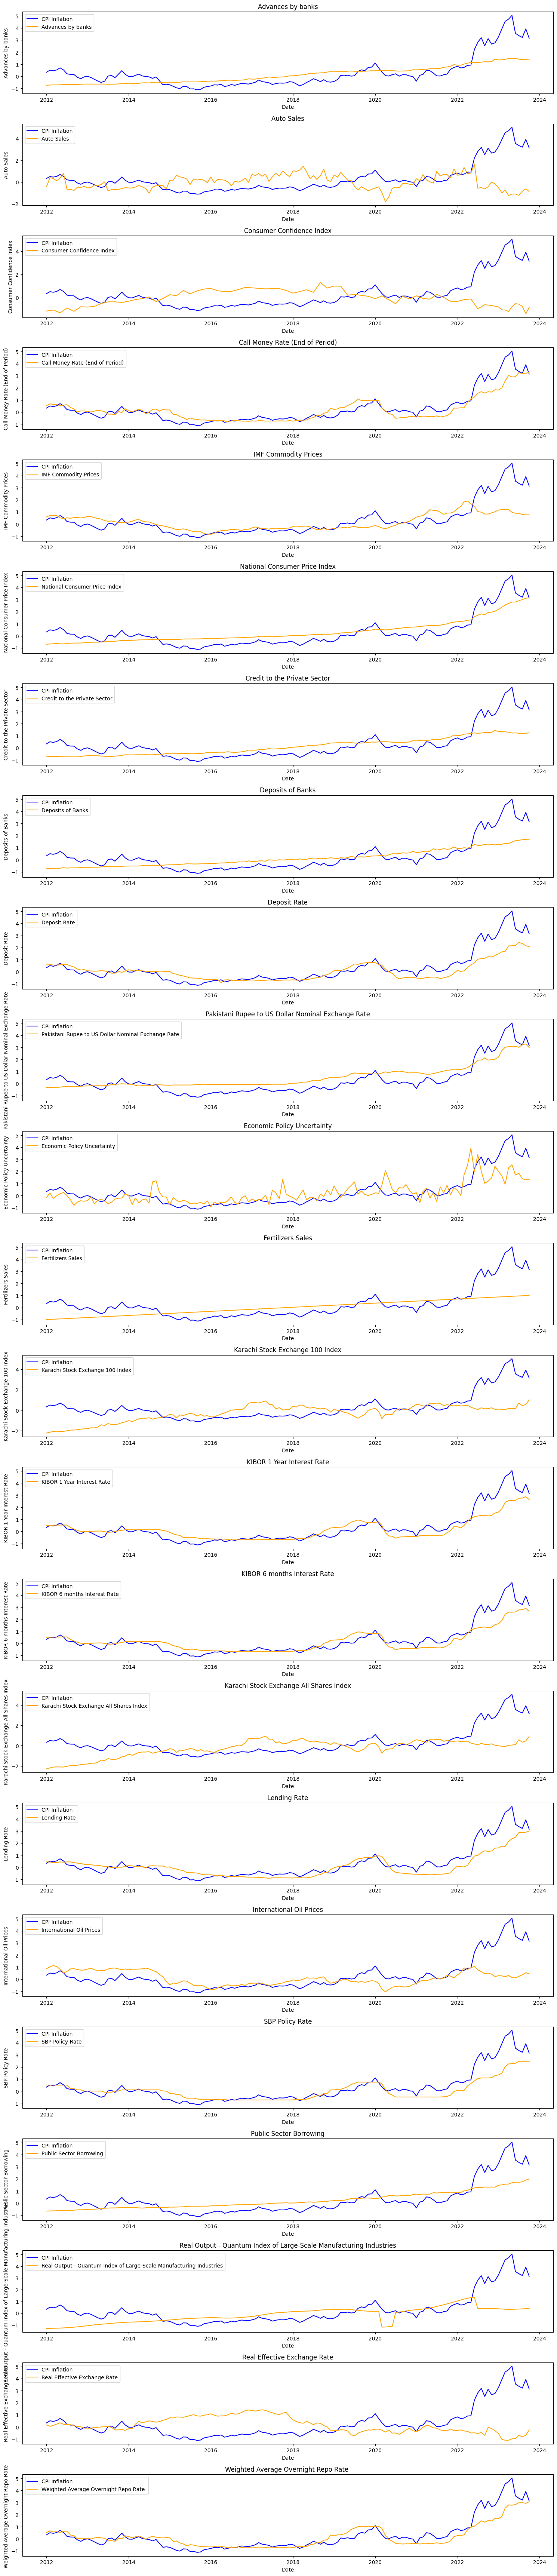

In [12]:
num_features = len(columns_to_plot) - 1  # Excluding 'CPI National Year on Year Inflation'
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(15, 3 * num_features))
axes = axes.flatten()

axis_index = 0

# Plot inflation against each feature in vertical stack
for column in columns_to_plot:
    if column != 'CPI National Year on Year Inflation':
        axes[axis_index].plot(data_final['Date'], data_final['CPI National Year on Year Inflation'], label='CPI Inflation', color='blue')
        axes[axis_index].plot(data_final['Date'], data_final[column], label=column, color='orange')
        axes[axis_index].set_title(column)
        axes[axis_index].set_xlabel('Date')
        axes[axis_index].set_ylabel(column)
        axes[axis_index].legend()
        axis_index += 1  # Move to the next axis

plt.tight_layout()
plt.savefig('inflation_with_other_features_vertical.png', bbox_inches='tight', dpi=700)
plt.show()

In [13]:
correlation_matrix = data_final.corr()

correlation_df = correlation_matrix.reset_index()

print("Full Correlation Matrix:")
print(correlation_df)
correlation_df.to_csv('correlation_matrix.csv', index=False)

Full Correlation Matrix:
                                                index      Date  \
0                                                Date  1.000000   
1                 CPI National Year on Year Inflation  0.603017   
2                                   Advances by banks  0.974914   
3                                          Auto Sales  0.036645   
4                           Consumer Confidence Index  0.014757   
5                     Call Money Rate (End of Period)  0.461505   
6                                IMF Commodity Prices  0.394833   
7                       National Consumer Price Index  0.892593   
8                        Credit to the Private Sector  0.978526   
9                                   Deposits of Banks  0.968122   
10                                       Deposit Rate  0.356620   
11  Pakistani Rupee to US Dollar Nominal Exchange ...  0.863029   
12                        Economic Policy Uncertainty  0.673248   
13                                  F

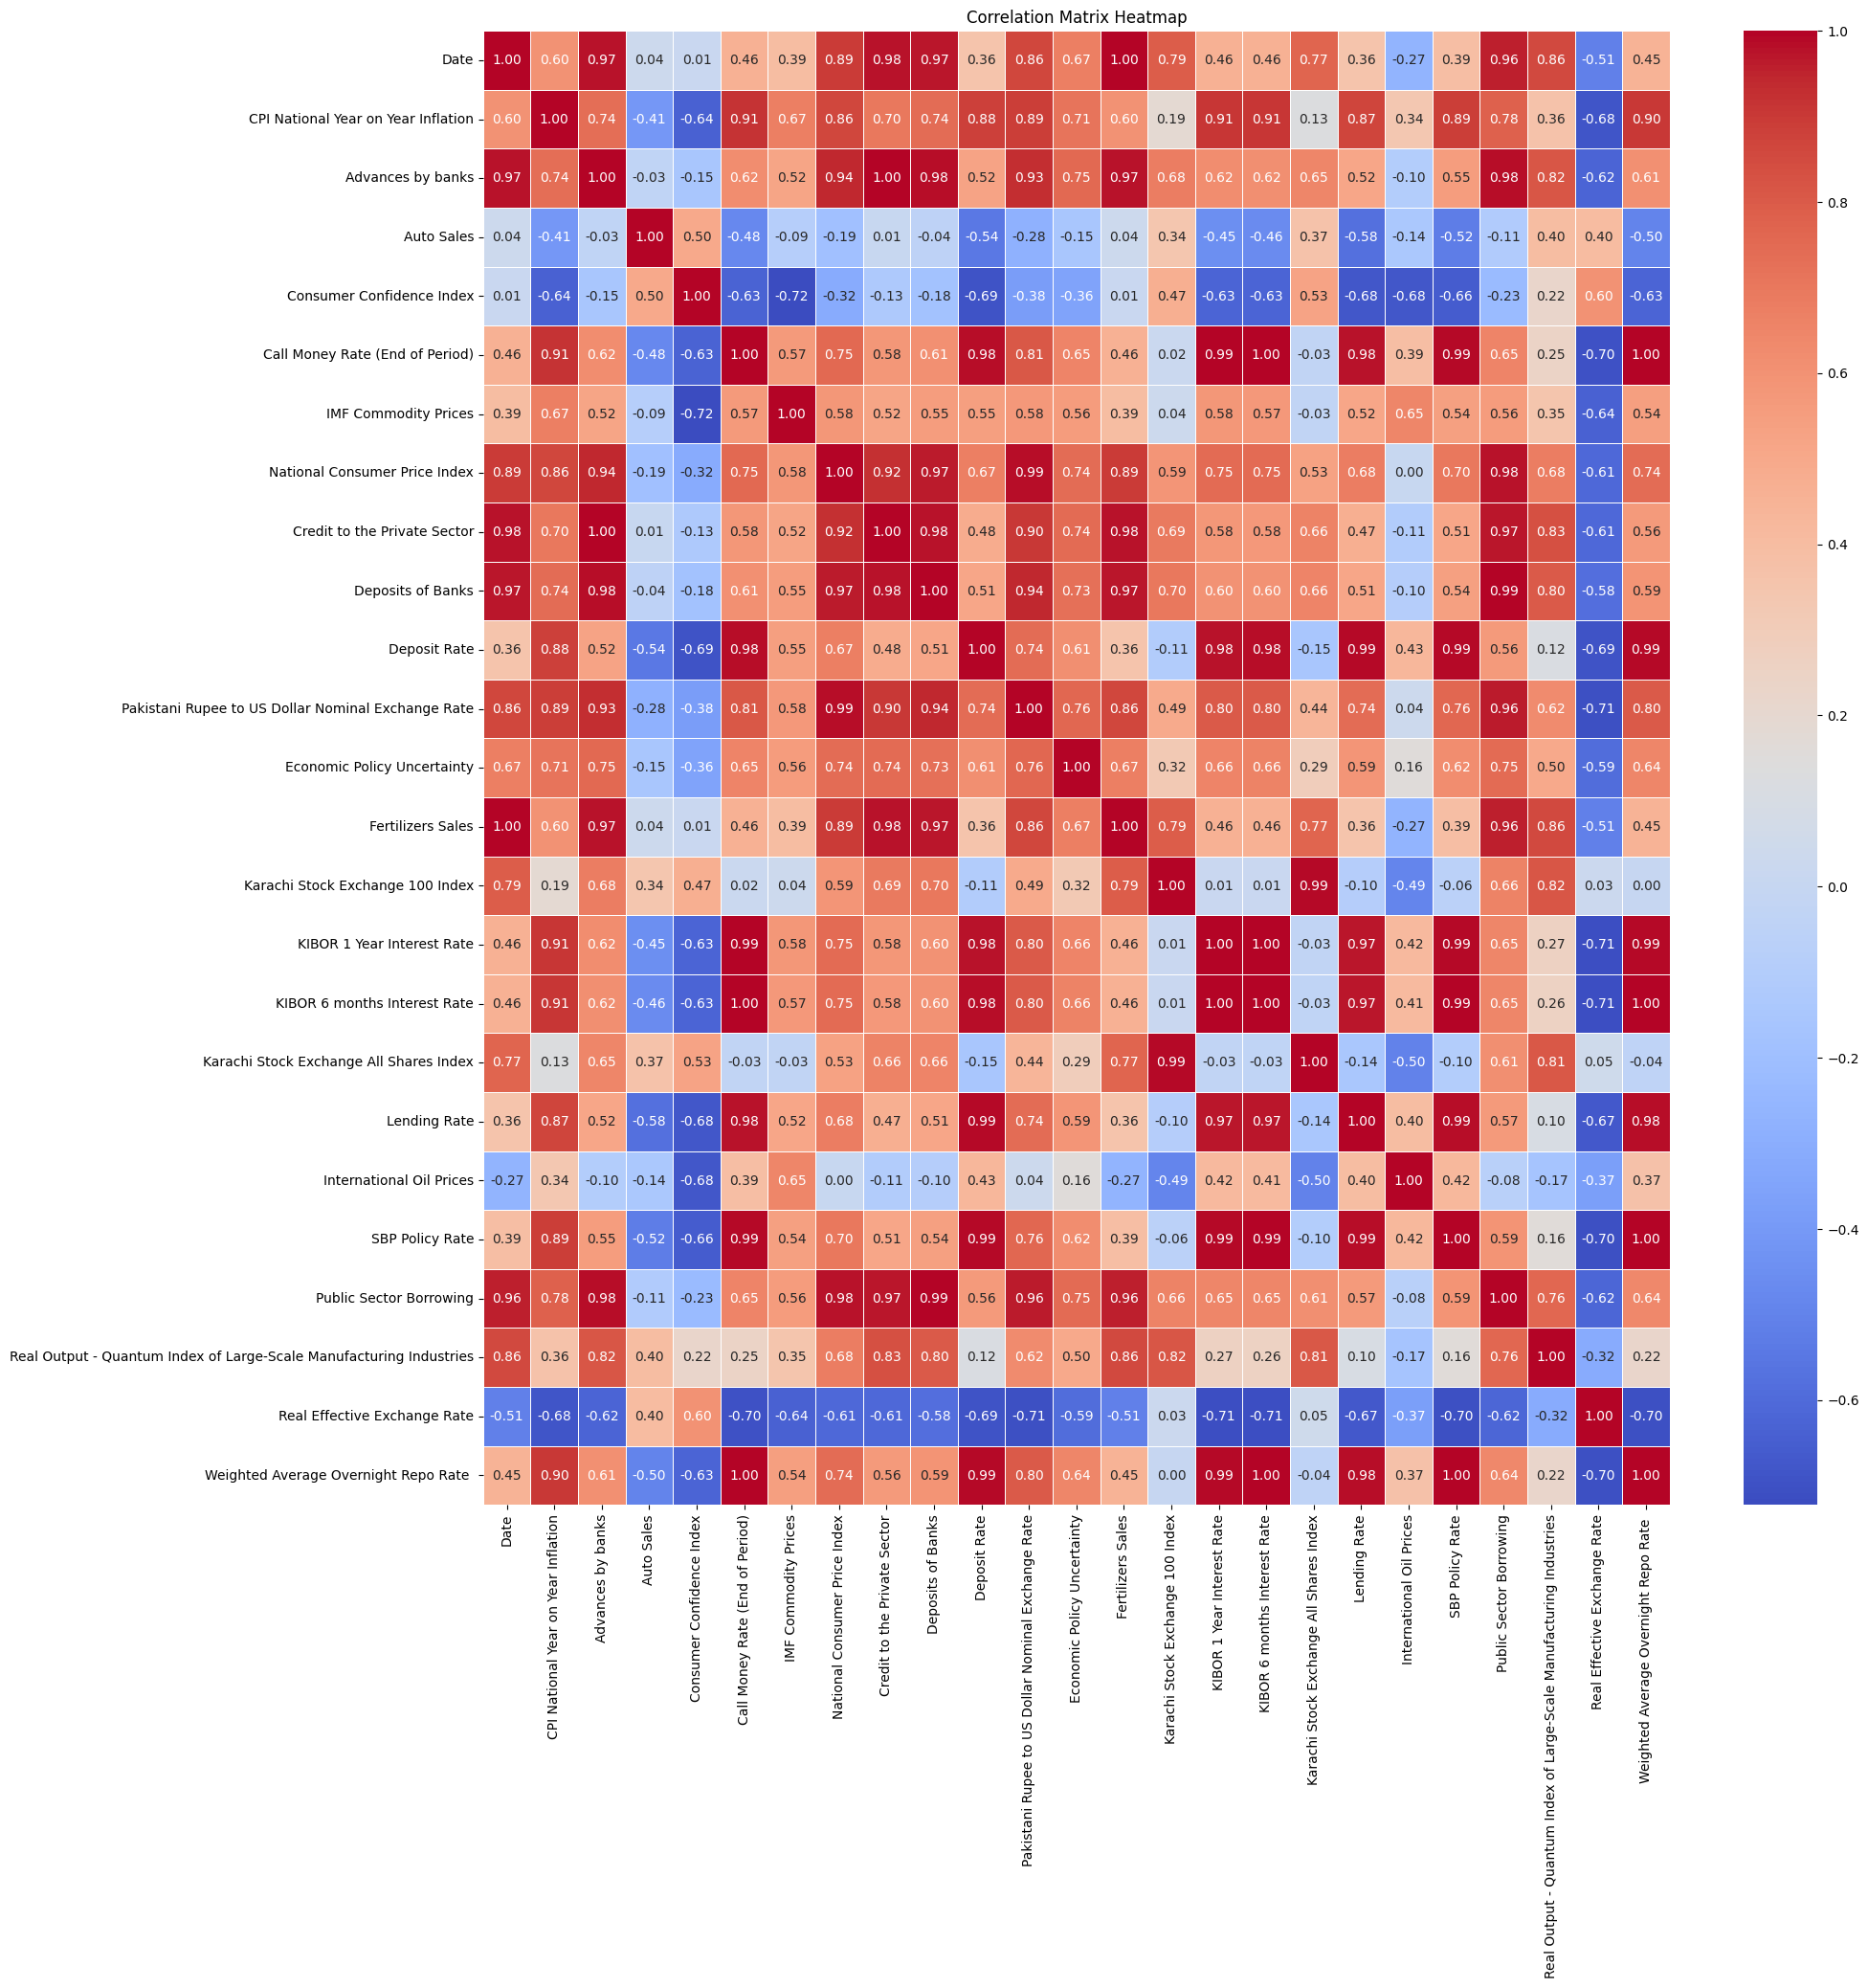

In [14]:
#Heatmap
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.savefig('full_correlation_heatmap.png', bbox_inches='tight', dpi=900)
plt.show()

In [15]:
# Threshold for multicollinearity
threshold = 0.8

# Pairs with multicollinearity
multicollinear_pairs_filtered = []

# Loop to find highly correlated feature pairs
for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[1]):  # only upper triangle
        corr_value = correlation_matrix.iloc[i, j]
        feature1 = correlation_matrix.columns[i]
        feature2 = correlation_matrix.columns[j]
        
        # Exclude pairs with 'Date' or 'CPI National Year on Year Inflation'
        if abs(corr_value) >= threshold and feature1 != 'Date' and feature2 != 'Date' and feature1 != 'CPI National Year on Year Inflation' and feature2 != 'CPI National Year on Year Inflation':
            multicollinear_pairs_filtered.append((feature1, feature2, corr_value))

print("Highly Correlated Feature Pairs (Excluding Date and CPI Inflation):")
for pair in multicollinear_pairs_filtered:
    print(f"{pair[0]} and {pair[1]}: correlation = {pair[2]:.2f}")

multicollinear_filtered_df = pd.DataFrame(multicollinear_pairs_filtered, columns=['Feature 1', 'Feature 2', 'Correlation'])
multicollinear_filtered_df.to_csv('filtered_multicollinear_pairs.csv', index=False)


Highly Correlated Feature Pairs (Excluding Date and CPI Inflation):
Advances by banks and National Consumer Price Index: correlation = 0.94
Advances by banks and Credit to the Private Sector: correlation = 1.00
Advances by banks and Deposits of Banks: correlation = 0.98
Advances by banks and Pakistani Rupee to US Dollar Nominal Exchange Rate: correlation = 0.93
Advances by banks and Fertilizers Sales: correlation = 0.97
Advances by banks and Public Sector Borrowing: correlation = 0.98
Advances by banks and Real Output - Quantum Index of Large-Scale Manufacturing Industries: correlation = 0.82
Call Money Rate (End of Period) and Deposit Rate: correlation = 0.98
Call Money Rate (End of Period) and Pakistani Rupee to US Dollar Nominal Exchange Rate: correlation = 0.81
Call Money Rate (End of Period) and KIBOR 1 Year Interest Rate: correlation = 0.99
Call Money Rate (End of Period) and KIBOR 6 months Interest Rate: correlation = 1.00
Call Money Rate (End of Period) and Lending Rate: correl

In [16]:
# Feature Engineering
data_final['Interest Rate Spread'] = data_final['KIBOR 1 Year Interest Rate'] - data_final['KIBOR 6 months Interest Rate']
data_final['Exchange Rate Differential'] = data_final['Real Effective Exchange Rate'] - data_final['Pakistani Rupee to US Dollar Nominal Exchange Rate']
data_final['Inflation Expectations'] = data_final['Call Money Rate (End of Period)'] - data_final['SBP Policy Rate']
data_final['Banking Activity Index'] = data_final['Advances by banks'] + data_final['Public Sector Borrowing'] - data_final['Deposits of Banks']
data_final['Stock Market Volatility'] = data_final['Karachi Stock Exchange 100 Index'].pct_change()
data_final['Commodity Price Index'] = data_final['IMF Commodity Prices'] / data_final['International Oil Prices']

# Feature Selection
columns_to_drop = [
    'Credit to the Private Sector',
    'Deposits of Banks',
    'Fertilizers Sales',
    'KIBOR 6 months Interest Rate',
    'Weighted Average Overnight Repo Rate ',
    'Karachi Stock Exchange All Shares Index'
]

data_final_cleaned = data_final.drop(columns=columns_to_drop)
data_final_cleaned.to_csv('data_final_cleaned.csv', index=False)

In [17]:
train = data_final_cleaned.loc[data_final_cleaned['Date'] <= '10/01/2022']
test = data_final_cleaned.loc[data_final_cleaned['Date'] > '10/01/2022']

In [18]:
print(train.shape)
print(test.shape)

(130, 25)
(12, 25)


In [19]:
# Extract Year, Month, and Day from the 'Date' column
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day
# Optionally drop the original 'Date' column
train = train.drop(columns=['Date'])


In [20]:
# Extract Year, Month, and Day from the 'Date' column
test['Year'] = test['Date'].dt.year
test['Month'] = test['Date'].dt.month
test['Day'] = test['Date'].dt.day
# Optionally drop the original 'Date' column
test = test.drop(columns=['Date'])


In [21]:
# Split the data into features (X) and target (y)
X_train = train.drop(columns=['CPI National Year on Year Inflation'])
y_train = train['CPI National Year on Year Inflation']

X_test = test.drop(columns=['CPI National Year on Year Inflation'])
y_test = test['CPI National Year on Year Inflation']

# Save the datasets to CSV files
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

print("Data saved successfully: X_train, X_test, y_train, y_test.")


Data saved successfully: X_train, X_test, y_train, y_test.


In [22]:
# Load the datasets from CSV files (preventing data leaks)
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

# Verify the shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (130, 26)
X_test shape: (12, 26)
y_train shape: (130, 1)
y_test shape: (12, 1)


In [23]:
print(X_train.isnull().sum())
print(y_train.isnull().sum())


Advances by banks                                                      0
Auto Sales                                                             0
Consumer Confidence Index                                              0
Call Money Rate (End of Period)                                        0
IMF Commodity Prices                                                   0
National Consumer Price Index                                          0
Deposit Rate                                                           0
Pakistani Rupee to US Dollar Nominal Exchange Rate                     0
Economic Policy Uncertainty                                            0
Karachi Stock Exchange 100 Index                                       0
KIBOR 1 Year Interest Rate                                             0
Lending Rate                                                           0
International Oil Prices                                               0
SBP Policy Rate                                    

In [24]:
X_train.fillna(X_train.mean(), inplace=True)
y_train.fillna(y_train.mean(), inplace=True)


In [55]:
def sarima_objective(trial):
    param_grid_sarima = {
        'order': (
            trial.suggest_int('p', 0, 3),  # AR term
            trial.suggest_int('d', 0, 2),  # Differencing term
            trial.suggest_int('q', 0, 3)   # MA term
        ),
        'seasonal_order': (
            trial.suggest_int('P', 0, 3),  # Seasonal AR term
            trial.suggest_int('D', 0, 2),  # Seasonal differencing term
            trial.suggest_int('Q', 0, 3),  # Seasonal MA term
            trial.suggest_int('s', 1, 12)  # Season length (e.g., 12 for monthly data)
        ),
        'trend': trial.suggest_categorical('trend', ['n', 'c', 't', 'ct']),  # No trend, constant, linear trend, constant + linear trend
        'enforce_stationarity': trial.suggest_categorical('enforce_stationarity', [True, False]),
        'enforce_invertibility': trial.suggest_categorical('enforce_invertibility', [True, False])
    }
# Train SARIMA model
    try:
        sarima_model = SARIMAX(
            y_train,
            order=param_grid_sarima['order'],
            seasonal_order=param_grid_sarima['seasonal_order'],
            trend=param_grid_sarima['trend'],  # Include trend parameter
            enforce_stationarity=param_grid_sarima['enforce_stationarity'],  # Include enforce_stationarity
            enforce_invertibility=param_grid_sarima['enforce_invertibility']  # Include enforce_invertibility
        ).fit(disp=False, maxiter=500)  # Set maxiter to 500 for better convergence
        
        # Predict and calculate RMSE
        y_pred_sarima = sarima_model.forecast(steps=len(y_test))
        rmse_sarima = mean_squared_error(y_test, y_pred_sarima, squared=False)
        return rmse_sarima  # Minimize RMSE
    except Exception as e:
        return np.inf  # Return a large value if the model fails

In [66]:
study_sarima = optuna.create_study(direction='minimize')
study_sarima.optimize(sarima_objective, n_trials=75)

[I 2024-12-30 10:04:47,547] A new study created in memory with name: no-name-40ec1505-e9da-4536-9760-ff00a78e607c
[I 2024-12-30 10:04:51,433] Trial 0 finished with value: 0.788093789188179 and parameters: {'p': 2, 'd': 0, 'q': 2, 'P': 2, 'D': 0, 'Q': 0, 's': 5, 'trend': 't', 'enforce_stationarity': True, 'enforce_invertibility': True}. Best is trial 0 with value: 0.788093789188179.
[I 2024-12-30 10:04:51,770] Trial 1 finished with value: 1.8642720899249536 and parameters: {'p': 3, 'd': 2, 'q': 0, 'P': 3, 'D': 0, 'Q': 1, 's': 5, 'trend': 'n', 'enforce_stationarity': False, 'enforce_invertibility': True}. Best is trial 0 with value: 0.788093789188179.
[I 2024-12-30 10:04:52,800] Trial 2 finished with value: 1.2975994784891978 and parameters: {'p': 0, 'd': 1, 'q': 3, 'P': 1, 'D': 1, 'Q': 1, 's': 12, 'trend': 'n', 'enforce_stationarity': True, 'enforce_invertibility': True}. Best is trial 0 with value: 0.788093789188179.
[I 2024-12-30 10:04:55,550] Trial 3 finished with value: 0.7911615415

In [67]:
print("Best SARIMA Parameters:", study_sarima.best_params)

Best SARIMA Parameters: {'p': 1, 'd': 1, 'q': 0, 'P': 2, 'D': 0, 'Q': 2, 's': 4, 'trend': 'n', 'enforce_stationarity': False, 'enforce_invertibility': False}


In [68]:
# Train a final SARIMA model with the best parameters
best_sarima_params = study_sarima.best_params
best_order = (best_sarima_params['p'], best_sarima_params['d'], best_sarima_params['q'])
best_seasonal_order = (best_sarima_params['P'], best_sarima_params['D'], best_sarima_params['Q'], best_sarima_params['s'])

final_sarima_model = SARIMAX(
    y_train,
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

In [69]:
# Forecast and evaluate the final model
y_pred_final = final_sarima_model.forecast(steps=len(y_test))
final_rmse = mean_squared_error(y_test, y_pred_final, squared=False)
print(f"Optimized SARIMA RMSE: {final_rmse}")

Optimized SARIMA RMSE: 0.439095473913692


In [70]:
# Prepare data (scaling and reshaping for LSTM input)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Scale features
X_test_scaled = scaler.transform(X_test)

In [71]:
# LSTM expects 3D input: [samples, time steps, features]
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])


In [72]:
y_train_reshaped = y_train.values  # Ensure y_train is in numpy format
y_test_reshaped = y_test.values


In [78]:
def lstm_objective(trial):
    # Define the hyperparameter search space
    n_units = trial.suggest_int("n_units", 32, 256)  # Number of LSTM units
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)  # Dropout rate
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)  # Learning rate
    batch_size = trial.suggest_int("batch_size", 16, 64)  # Batch size
    epochs = trial.suggest_int("epochs", 10, 50)  # Number of epochs

    # Build the LSTM model
    model = Sequential([
        LSTM(n_units, activation='tanh', input_shape=(1, X_train_scaled.shape[1])),
        Dropout(dropout_rate),
        Dense(1)  # Output layer
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mse')

    # Train the model
    try:
        history = model.fit(X_train_reshaped, y_train_reshaped,
                            epochs=epochs, batch_size=batch_size, verbose=0)
        # Evaluate on test data
        y_pred_lstm = model.predict(X_test_reshaped).flatten()  # Flatten for comparison
        rmse_lstm = mean_squared_error(y_test_reshaped, y_pred_lstm, squared=False)
        return rmse_lstm  # Minimize RMSE
    except Exception as e:
        return np.inf  # Return a large value if the model fails
    
# Run Optuna study for LSTM
study_lstm = optuna.create_study(direction="minimize")
study_lstm.optimize(lstm_objective, n_trials=500)


In [80]:
# Run Optuna study for LSTM
study_lstm = optuna.create_study(direction="minimize")
study_lstm.optimize(lstm_objective, n_trials=500)


[I 2024-12-30 10:31:57,803] A new study created in memory with name: no-name-4a0972fa-d2e8-4f76-a9b6-fc1ec0b1e58d


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:32:00,840] Trial 0 finished with value: 0.6940975968256382 and parameters: {'n_units': 42, 'dropout_rate': 0.35144971356121524, 'learning_rate': 0.003601257760255217, 'batch_size': 38, 'epochs': 32}. Best is trial 0 with value: 0.6940975968256382.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:32:03,761] Trial 1 finished with value: 2.221271190151909 and parameters: {'n_units': 102, 'dropout_rate': 0.17273927754200352, 'learning_rate': 0.000290595251551165, 'batch_size': 41, 'epochs': 29}. Best is trial 0 with value: 0.6940975968256382.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-12-30 10:32:06,403] Trial 2 finished with value: 3.2040096794537707 and parameters: {'n_units': 66, 'dropout_rate': 0.32593389285294705, 'learning_rate': 0.0002006178354750186, 'batch_size': 57, 'epochs': 25}. Best is trial 0 with value: 0.6940975968256382.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-12-30 10:32:10,151] Trial 3 finished with value: 1.2367740361203952 and parameters: {'n_units': 120, 'dropout_rate': 0.27749089659037407, 'learning_rate': 0.008063346020368834, 'batch_size': 19, 'epochs': 44}. Best is trial 0 with value: 0.6940975968256382.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:32:13,343] Trial 4 finished with value: 3.0787318418214924 and parameters: {'n_units': 43, 'dropout_rate': 0.32999441142693753, 'learning_rate': 0.00013488243730627248, 'batch_size': 58, 'epochs': 44}. Best is trial 0 with value: 0.6940975968256382.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:32:16,951] Trial 5 finished with value: 0.7671152849627841 and parameters: {'n_units': 223, 'dropout_rate': 0.23499700791217581, 'learning_rate': 0.0008084985743147629, 'batch_size': 40, 'epochs': 39}. Best is trial 0 with value: 0.6940975968256382.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:32:20,145] Trial 6 finished with value: 0.8086181018944345 and parameters: {'n_units': 77, 'dropout_rate': 0.444527239900525, 'learning_rate': 0.004400467684502137, 'batch_size': 44, 'epochs': 43}. Best is trial 0 with value: 0.6940975968256382.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:32:22,978] Trial 7 finished with value: 2.15003368367752 and parameters: {'n_units': 148, 'dropout_rate': 0.44857694892487876, 'learning_rate': 0.0003482629177669902, 'batch_size': 47, 'epochs': 28}. Best is trial 0 with value: 0.6940975968256382.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-12-30 10:32:26,465] Trial 8 finished with value: 1.0549856608075974 and parameters: {'n_units': 164, 'dropout_rate': 0.25330444868701496, 'learning_rate': 0.0028997703909399335, 'batch_size': 50, 'epochs': 47}. Best is trial 0 with value: 0.6940975968256382.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


[I 2024-12-30 10:32:29,809] Trial 9 finished with value: 0.6806655796440192 and parameters: {'n_units': 36, 'dropout_rate': 0.39935505722535525, 'learning_rate': 0.0032965406263737768, 'batch_size': 38, 'epochs': 45}. Best is trial 9 with value: 0.6806655796440192.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:32:32,261] Trial 10 finished with value: 0.9224396878965064 and parameters: {'n_units': 200, 'dropout_rate': 0.1073582596854066, 'learning_rate': 0.001627265773541801, 'batch_size': 27, 'epochs': 11}. Best is trial 9 with value: 0.6806655796440192.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-12-30 10:32:35,383] Trial 11 finished with value: 0.7414981216062299 and parameters: {'n_units': 32, 'dropout_rate': 0.38237707190419096, 'learning_rate': 0.009091208725700769, 'batch_size': 34, 'epochs': 35}. Best is trial 9 with value: 0.6806655796440192.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


[I 2024-12-30 10:32:38,058] Trial 12 finished with value: 0.8793892272870645 and parameters: {'n_units': 81, 'dropout_rate': 0.3889983976967667, 'learning_rate': 0.0015868164014601206, 'batch_size': 30, 'epochs': 19}. Best is trial 9 with value: 0.6806655796440192.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:32:41,553] Trial 13 finished with value: 0.7223432616129272 and parameters: {'n_units': 53, 'dropout_rate': 0.4949121055560882, 'learning_rate': 0.0038930681038086873, 'batch_size': 35, 'epochs': 50}. Best is trial 9 with value: 0.6806655796440192.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:32:44,800] Trial 14 finished with value: 0.7782799327607262 and parameters: {'n_units': 118, 'dropout_rate': 0.38647054775106093, 'learning_rate': 0.0007085408526385361, 'batch_size': 23, 'epochs': 35}. Best is trial 9 with value: 0.6806655796440192.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2024-12-30 10:32:47,483] Trial 15 finished with value: 0.8508911395392059 and parameters: {'n_units': 181, 'dropout_rate': 0.3388136940715186, 'learning_rate': 0.0022391515825874978, 'batch_size': 53, 'epochs': 19}. Best is trial 9 with value: 0.6806655796440192.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:32:50,689] Trial 16 finished with value: 1.0180579933847753 and parameters: {'n_units': 94, 'dropout_rate': 0.42833961485705246, 'learning_rate': 0.00548170777941269, 'batch_size': 36, 'epochs': 35}. Best is trial 9 with value: 0.6806655796440192.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


[I 2024-12-30 10:32:53,516] Trial 17 finished with value: 0.9934896877375033 and parameters: {'n_units': 32, 'dropout_rate': 0.2038131859701365, 'learning_rate': 0.0015240465728144055, 'batch_size': 16, 'epochs': 23}. Best is trial 9 with value: 0.6806655796440192.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-12-30 10:32:57,015] Trial 18 finished with value: 1.119097893418726 and parameters: {'n_units': 253, 'dropout_rate': 0.4926943632268701, 'learning_rate': 0.0005742716701138178, 'batch_size': 64, 'epochs': 40}. Best is trial 9 with value: 0.6806655796440192.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:33:00,054] Trial 19 finished with value: 0.7081946749312714 and parameters: {'n_units': 62, 'dropout_rate': 0.3587125552024139, 'learning_rate': 0.0027268900254406618, 'batch_size': 30, 'epochs': 32}. Best is trial 9 with value: 0.6806655796440192.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-12-30 10:33:03,259] Trial 20 finished with value: 1.249795902696951 and parameters: {'n_units': 123, 'dropout_rate': 0.29824040161903403, 'learning_rate': 0.005951622931988546, 'batch_size': 45, 'epochs': 39}. Best is trial 9 with value: 0.6806655796440192.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:33:06,248] Trial 21 finished with value: 0.711774692769836 and parameters: {'n_units': 60, 'dropout_rate': 0.361126875448311, 'learning_rate': 0.002640772206327574, 'batch_size': 29, 'epochs': 32}. Best is trial 9 with value: 0.6806655796440192.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:33:09,279] Trial 22 finished with value: 0.7243956045620681 and parameters: {'n_units': 54, 'dropout_rate': 0.4224756659353607, 'learning_rate': 0.0030822399948701646, 'batch_size': 33, 'epochs': 32}. Best is trial 9 with value: 0.6806655796440192.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:33:12,140] Trial 23 finished with value: 0.9282634844281642 and parameters: {'n_units': 82, 'dropout_rate': 0.35955899659576884, 'learning_rate': 0.0010822534394530298, 'batch_size': 25, 'epochs': 25}. Best is trial 9 with value: 0.6806655796440192.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:33:14,441] Trial 24 finished with value: 0.9515836770160244 and parameters: {'n_units': 46, 'dropout_rate': 0.3019114859220676, 'learning_rate': 0.006146999325524533, 'batch_size': 37, 'epochs': 11}. Best is trial 9 with value: 0.6806655796440192.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


[I 2024-12-30 10:33:18,164] Trial 25 finished with value: 1.0637610234639423 and parameters: {'n_units': 101, 'dropout_rate': 0.4092736465267091, 'learning_rate': 0.003910606634271806, 'batch_size': 31, 'epochs': 50}. Best is trial 9 with value: 0.6806655796440192.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-12-30 10:33:20,779] Trial 26 finished with value: 1.0386481098170877 and parameters: {'n_units': 73, 'dropout_rate': 0.4596053452277462, 'learning_rate': 0.0019750820393470044, 'batch_size': 39, 'epochs': 18}. Best is trial 9 with value: 0.6806655796440192.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:33:24,011] Trial 27 finished with value: 0.8794906470694451 and parameters: {'n_units': 45, 'dropout_rate': 0.37108573789221705, 'learning_rate': 0.001151760551755359, 'batch_size': 23, 'epochs': 37}. Best is trial 9 with value: 0.6806655796440192.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2024-12-30 10:33:26,511] Trial 28 finished with value: 1.0607692470077403 and parameters: {'n_units': 138, 'dropout_rate': 0.3073674223826475, 'learning_rate': 0.0031720319883557723, 'batch_size': 43, 'epochs': 15}. Best is trial 9 with value: 0.6806655796440192.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:33:29,481] Trial 29 finished with value: 0.6874870198758554 and parameters: {'n_units': 32, 'dropout_rate': 0.1538242149105515, 'learning_rate': 0.009927026779511839, 'batch_size': 40, 'epochs': 32}. Best is trial 9 with value: 0.6806655796440192.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:33:32,347] Trial 30 finished with value: 0.7877755663729388 and parameters: {'n_units': 91, 'dropout_rate': 0.13497047636392207, 'learning_rate': 0.009714406950150288, 'batch_size': 41, 'epochs': 28}. Best is trial 9 with value: 0.6806655796440192.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:33:35,240] Trial 31 finished with value: 0.8187803846048625 and parameters: {'n_units': 35, 'dropout_rate': 0.21913439016338093, 'learning_rate': 0.0068588734712439715, 'batch_size': 38, 'epochs': 31}. Best is trial 9 with value: 0.6806655796440192.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


[I 2024-12-30 10:33:38,107] Trial 32 finished with value: 0.7363383909399224 and parameters: {'n_units': 65, 'dropout_rate': 0.14359024035770332, 'learning_rate': 0.004657271202524644, 'batch_size': 32, 'epochs': 25}. Best is trial 9 with value: 0.6806655796440192.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


[I 2024-12-30 10:33:47,128] Trial 33 finished with value: 0.8111731064959355 and parameters: {'n_units': 62, 'dropout_rate': 0.27089982850395267, 'learning_rate': 0.0020853093689521033, 'batch_size': 48, 'epochs': 29}. Best is trial 9 with value: 0.6806655796440192.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


[I 2024-12-30 10:33:50,791] Trial 34 finished with value: 0.6577413571582066 and parameters: {'n_units': 47, 'dropout_rate': 0.34151772475366804, 'learning_rate': 0.007547444090027426, 'batch_size': 42, 'epochs': 42}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2024-12-30 10:33:54,515] Trial 35 finished with value: 0.6905877920475233 and parameters: {'n_units': 46, 'dropout_rate': 0.19083897801439684, 'learning_rate': 0.008401616324174063, 'batch_size': 43, 'epochs': 43}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


[I 2024-12-30 10:33:58,040] Trial 36 finished with value: 0.8482053564580073 and parameters: {'n_units': 48, 'dropout_rate': 0.1682340901398319, 'learning_rate': 0.0075492475006740944, 'batch_size': 52, 'epochs': 42}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


[I 2024-12-30 10:34:01,795] Trial 37 finished with value: 0.7378111622657559 and parameters: {'n_units': 42, 'dropout_rate': 0.19519341601619966, 'learning_rate': 0.009876699636726917, 'batch_size': 42, 'epochs': 46}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


[I 2024-12-30 10:34:05,407] Trial 38 finished with value: 1.0497442233081826 and parameters: {'n_units': 74, 'dropout_rate': 0.10381443863933511, 'learning_rate': 0.004975569374294059, 'batch_size': 46, 'epochs': 47}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


[I 2024-12-30 10:34:08,937] Trial 39 finished with value: 1.1603663362802497 and parameters: {'n_units': 114, 'dropout_rate': 0.17282927261876407, 'learning_rate': 0.007187263332505974, 'batch_size': 56, 'epochs': 42}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


[I 2024-12-30 10:34:12,401] Trial 40 finished with value: 0.7969296306909153 and parameters: {'n_units': 32, 'dropout_rate': 0.24565975119796624, 'learning_rate': 0.008003109689847155, 'batch_size': 49, 'epochs': 45}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


[I 2024-12-30 10:34:15,798] Trial 41 finished with value: 0.8012608424706895 and parameters: {'n_units': 49, 'dropout_rate': 0.33499337646366684, 'learning_rate': 0.0038879533642453136, 'batch_size': 40, 'epochs': 42}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-12-30 10:34:19,069] Trial 42 finished with value: 2.650416028614783 and parameters: {'n_units': 69, 'dropout_rate': 0.1398014088617594, 'learning_rate': 0.00022689227448706027, 'batch_size': 42, 'epochs': 37}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


[I 2024-12-30 10:34:22,380] Trial 43 finished with value: 0.8808340713430682 and parameters: {'n_units': 41, 'dropout_rate': 0.27857080889792607, 'learning_rate': 0.005622095578332376, 'batch_size': 37, 'epochs': 40}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:34:25,921] Trial 44 finished with value: 0.9652637634673357 and parameters: {'n_units': 58, 'dropout_rate': 0.31381387708743963, 'learning_rate': 0.008362422329703122, 'batch_size': 44, 'epochs': 48}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:34:29,396] Trial 45 finished with value: 1.110649045104392 and parameters: {'n_units': 85, 'dropout_rate': 0.16691363308511506, 'learning_rate': 0.00044651645141006427, 'batch_size': 35, 'epochs': 44}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-12-30 10:34:32,497] Trial 46 finished with value: 0.6919378366325593 and parameters: {'n_units': 40, 'dropout_rate': 0.4022128746707014, 'learning_rate': 0.004451298952479531, 'batch_size': 39, 'epochs': 34}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:34:35,578] Trial 47 finished with value: 0.677258811392501 and parameters: {'n_units': 39, 'dropout_rate': 0.4707357745436297, 'learning_rate': 0.004824748053805606, 'batch_size': 47, 'epochs': 37}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:34:38,721] Trial 48 finished with value: 0.6645091787164499 and parameters: {'n_units': 50, 'dropout_rate': 0.4472128752852223, 'learning_rate': 0.006686421069945143, 'batch_size': 51, 'epochs': 37}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:34:41,821] Trial 49 finished with value: 3.3564773646291175 and parameters: {'n_units': 54, 'dropout_rate': 0.46484898694510546, 'learning_rate': 0.00012533635834041765, 'batch_size': 56, 'epochs': 38}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:34:45,064] Trial 50 finished with value: 0.8814999773281104 and parameters: {'n_units': 194, 'dropout_rate': 0.47612569792380743, 'learning_rate': 0.006609010867959976, 'batch_size': 60, 'epochs': 36}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:34:48,244] Trial 51 finished with value: 0.7525264413127097 and parameters: {'n_units': 41, 'dropout_rate': 0.44557681498457913, 'learning_rate': 0.009880375262834494, 'batch_size': 51, 'epochs': 40}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-12-30 10:34:51,454] Trial 52 finished with value: 0.6837013272813733 and parameters: {'n_units': 32, 'dropout_rate': 0.4253859282044336, 'learning_rate': 0.005228810275549012, 'batch_size': 46, 'epochs': 44}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-12-30 10:34:54,955] Trial 53 finished with value: 0.6835970900950463 and parameters: {'n_units': 33, 'dropout_rate': 0.4353493138813918, 'learning_rate': 0.004852240864130338, 'batch_size': 47, 'epochs': 48}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-12-30 10:34:58,366] Trial 54 finished with value: 0.7490109303729442 and parameters: {'n_units': 56, 'dropout_rate': 0.42859820183530417, 'learning_rate': 0.003585146966315848, 'batch_size': 47, 'epochs': 48}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:35:01,853] Trial 55 finished with value: 0.9937266781481467 and parameters: {'n_units': 162, 'dropout_rate': 0.48097991197108525, 'learning_rate': 0.005268027840589358, 'batch_size': 54, 'epochs': 45}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:35:05,228] Trial 56 finished with value: 0.7735356253664999 and parameters: {'n_units': 69, 'dropout_rate': 0.40562199548355643, 'learning_rate': 0.003343038726287287, 'batch_size': 50, 'epochs': 48}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-12-30 10:35:08,791] Trial 57 finished with value: 0.9903006263951168 and parameters: {'n_units': 236, 'dropout_rate': 0.4337436876720841, 'learning_rate': 0.002367917045155739, 'batch_size': 46, 'epochs': 41}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-12-30 10:35:12,255] Trial 58 finished with value: 0.6607434975471044 and parameters: {'n_units': 37, 'dropout_rate': 0.45134806702958385, 'learning_rate': 0.004331334584659872, 'batch_size': 54, 'epochs': 50}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-12-30 10:35:15,656] Trial 59 finished with value: 0.8466094978062699 and parameters: {'n_units': 51, 'dropout_rate': 0.4574183889411892, 'learning_rate': 0.0065438623117285, 'batch_size': 54, 'epochs': 50}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2024-12-30 10:35:18,989] Trial 60 finished with value: 0.7945179853203687 and parameters: {'n_units': 79, 'dropout_rate': 0.4977340943404078, 'learning_rate': 0.003982396122708885, 'batch_size': 60, 'epochs': 46}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:35:22,172] Trial 61 finished with value: 0.714181716838935 and parameters: {'n_units': 37, 'dropout_rate': 0.4139387565792433, 'learning_rate': 0.004787183887611907, 'batch_size': 49, 'epochs': 44}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


[I 2024-12-30 10:35:25,534] Trial 62 finished with value: 0.7136176820502683 and parameters: {'n_units': 39, 'dropout_rate': 0.3894930948213834, 'learning_rate': 0.005751056434204585, 'batch_size': 51, 'epochs': 49}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


[I 2024-12-30 10:35:28,888] Trial 63 finished with value: 0.8227950667749905 and parameters: {'n_units': 32, 'dropout_rate': 0.4390828272642292, 'learning_rate': 0.002826438605625375, 'batch_size': 45, 'epochs': 46}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:35:32,088] Trial 64 finished with value: 0.7095932129611415 and parameters: {'n_units': 52, 'dropout_rate': 0.4744572096307341, 'learning_rate': 0.004267389818487972, 'batch_size': 54, 'epochs': 43}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-12-30 10:35:35,135] Trial 65 finished with value: 0.8369662678746286 and parameters: {'n_units': 56, 'dropout_rate': 0.45137065016664535, 'learning_rate': 0.0017175244279974834, 'batch_size': 49, 'epochs': 39}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


[I 2024-12-30 10:35:38,120] Trial 66 finished with value: 0.773055187181624 and parameters: {'n_units': 62, 'dropout_rate': 0.4188344673803813, 'learning_rate': 0.005151916959999733, 'batch_size': 47, 'epochs': 34}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:35:41,461] Trial 67 finished with value: 0.9277179358154635 and parameters: {'n_units': 49, 'dropout_rate': 0.375169988116852, 'learning_rate': 0.0013632542803839521, 'batch_size': 44, 'epochs': 47}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-12-30 10:35:44,860] Trial 68 finished with value: 0.7067226041182444 and parameters: {'n_units': 68, 'dropout_rate': 0.34857163669383284, 'learning_rate': 0.0024711565747124885, 'batch_size': 59, 'epochs': 50}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


[I 2024-12-30 10:35:48,172] Trial 69 finished with value: 0.6870365215280992 and parameters: {'n_units': 44, 'dropout_rate': 0.40148845885141343, 'learning_rate': 0.006201426902349657, 'batch_size': 63, 'epochs': 45}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:35:51,302] Trial 70 finished with value: 0.6820494981334658 and parameters: {'n_units': 36, 'dropout_rate': 0.46650307060295537, 'learning_rate': 0.003033072075518928, 'batch_size': 52, 'epochs': 41}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:35:54,522] Trial 71 finished with value: 0.7653885577559661 and parameters: {'n_units': 37, 'dropout_rate': 0.46686248742629527, 'learning_rate': 0.0033024412839219876, 'batch_size': 52, 'epochs': 41}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:35:57,714] Trial 72 finished with value: 1.2714929054140196 and parameters: {'n_units': 44, 'dropout_rate': 0.4465983604199113, 'learning_rate': 0.000778625509706475, 'batch_size': 48, 'epochs': 41}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:36:00,862] Trial 73 finished with value: 0.8160372400011645 and parameters: {'n_units': 35, 'dropout_rate': 0.4838757704837387, 'learning_rate': 0.003587754586595022, 'batch_size': 53, 'epochs': 38}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:36:04,100] Trial 74 finished with value: 0.7299682317153712 and parameters: {'n_units': 59, 'dropout_rate': 0.43060643281823313, 'learning_rate': 0.007293789522957905, 'batch_size': 57, 'epochs': 43}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:36:07,398] Trial 75 finished with value: 0.7102588702326498 and parameters: {'n_units': 47, 'dropout_rate': 0.39124037830058706, 'learning_rate': 0.004635358204622093, 'batch_size': 46, 'epochs': 44}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:36:10,806] Trial 76 finished with value: 0.7652251168118752 and parameters: {'n_units': 32, 'dropout_rate': 0.45722962887224944, 'learning_rate': 0.0028656391910313705, 'batch_size': 55, 'epochs': 48}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:36:14,186] Trial 77 finished with value: 0.665489359962305 and parameters: {'n_units': 39, 'dropout_rate': 0.42268653482992413, 'learning_rate': 0.004119049193104302, 'batch_size': 42, 'epochs': 47}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:36:17,645] Trial 78 finished with value: 0.955684548690197 and parameters: {'n_units': 40, 'dropout_rate': 0.490144180894464, 'learning_rate': 0.0018487170161842416, 'batch_size': 42, 'epochs': 49}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


[I 2024-12-30 10:36:20,980] Trial 79 finished with value: 0.8890289035694396 and parameters: {'n_units': 65, 'dropout_rate': 0.4399505873808, 'learning_rate': 0.004276002927967899, 'batch_size': 51, 'epochs': 47}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:36:24,305] Trial 80 finished with value: 3.310390473173351 and parameters: {'n_units': 52, 'dropout_rate': 0.4683130105843489, 'learning_rate': 0.00010319573030422943, 'batch_size': 44, 'epochs': 46}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


[I 2024-12-30 10:36:27,669] Trial 81 finished with value: 0.8066181263656206 and parameters: {'n_units': 39, 'dropout_rate': 0.42286410869219815, 'learning_rate': 0.005893117202830051, 'batch_size': 48, 'epochs': 49}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-12-30 10:36:31,168] Trial 82 finished with value: 0.7978950225512313 and parameters: {'n_units': 47, 'dropout_rate': 0.4522703076255741, 'learning_rate': 0.0052656284463040446, 'batch_size': 41, 'epochs': 45}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-12-30 10:36:34,314] Trial 83 finished with value: 0.7145821923965399 and parameters: {'n_units': 32, 'dropout_rate': 0.41766301216466745, 'learning_rate': 0.00868024637037683, 'batch_size': 39, 'epochs': 38}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:36:37,646] Trial 84 finished with value: 0.7305475100482401 and parameters: {'n_units': 43, 'dropout_rate': 0.39754571193498445, 'learning_rate': 0.007440614237369283, 'batch_size': 37, 'epochs': 42}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:36:40,694] Trial 85 finished with value: 0.6815775204769667 and parameters: {'n_units': 60, 'dropout_rate': 0.4381239975111938, 'learning_rate': 0.0038579122407264924, 'batch_size': 50, 'epochs': 36}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


[I 2024-12-30 10:36:43,692] Trial 86 finished with value: 0.6839784950200231 and parameters: {'n_units': 58, 'dropout_rate': 0.43758764230644315, 'learning_rate': 0.0035893442086354856, 'batch_size': 53, 'epochs': 36}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-12-30 10:36:46,654] Trial 87 finished with value: 0.7081696441005232 and parameters: {'n_units': 75, 'dropout_rate': 0.37398148880228044, 'learning_rate': 0.00310494131547285, 'batch_size': 50, 'epochs': 34}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2024-12-30 10:36:49,900] Trial 88 finished with value: 0.7404534660400593 and parameters: {'n_units': 132, 'dropout_rate': 0.48626881653208825, 'learning_rate': 0.002164163903631771, 'batch_size': 52, 'epochs': 40}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-12-30 10:36:53,138] Trial 89 finished with value: 0.9110676324057598 and parameters: {'n_units': 110, 'dropout_rate': 0.46534047568407927, 'learning_rate': 0.002544209619910005, 'batch_size': 43, 'epochs': 37}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:36:56,097] Trial 90 finished with value: 0.6882770630295091 and parameters: {'n_units': 52, 'dropout_rate': 0.447960180253033, 'learning_rate': 0.0038539734852581224, 'batch_size': 35, 'epochs': 33}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-12-30 10:36:59,257] Trial 91 finished with value: 0.7282377547848019 and parameters: {'n_units': 38, 'dropout_rate': 0.4274489872944584, 'learning_rate': 0.004135276600026425, 'batch_size': 45, 'epochs': 39}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:37:02,404] Trial 92 finished with value: 0.6898022330756273 and parameters: {'n_units': 45, 'dropout_rate': 0.4114956279991934, 'learning_rate': 0.004765959206753585, 'batch_size': 47, 'epochs': 36}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:37:05,621] Trial 93 finished with value: 0.7138725220388121 and parameters: {'n_units': 36, 'dropout_rate': 0.45638030936485297, 'learning_rate': 0.006587181574686673, 'batch_size': 49, 'epochs': 43}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:37:08,524] Trial 94 finished with value: 0.7013835420422817 and parameters: {'n_units': 50, 'dropout_rate': 0.4732713881434526, 'learning_rate': 0.00549145812999106, 'batch_size': 45, 'epochs': 30}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2024-12-30 10:37:11,955] Trial 95 finished with value: 0.7905916466275011 and parameters: {'n_units': 64, 'dropout_rate': 0.31990246843032805, 'learning_rate': 0.004916988467335952, 'batch_size': 41, 'epochs': 46}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:37:15,227] Trial 96 finished with value: 0.7921528229004121 and parameters: {'n_units': 56, 'dropout_rate': 0.4344875948906157, 'learning_rate': 0.007761075479554144, 'batch_size': 50, 'epochs': 44}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:37:18,762] Trial 97 finished with value: 0.8827316377531025 and parameters: {'n_units': 86, 'dropout_rate': 0.4198944636299512, 'learning_rate': 0.0034071354758036503, 'batch_size': 48, 'epochs': 49}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-12-30 10:37:22,004] Trial 98 finished with value: 0.9297307519366036 and parameters: {'n_units': 71, 'dropout_rate': 0.38299083335972245, 'learning_rate': 0.0061367522324143045, 'batch_size': 46, 'epochs': 41}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:37:25,577] Trial 99 finished with value: 0.858447781836441 and parameters: {'n_units': 153, 'dropout_rate': 0.4427957720416066, 'learning_rate': 0.002958485684128984, 'batch_size': 56, 'epochs': 47}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


[I 2024-12-30 10:37:28,966] Trial 100 finished with value: 0.6982287921075732 and parameters: {'n_units': 36, 'dropout_rate': 0.39742214918692037, 'learning_rate': 0.004306701856747849, 'batch_size': 38, 'epochs': 45}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


[I 2024-12-30 10:37:31,992] Trial 101 finished with value: 0.7030883942137143 and parameters: {'n_units': 58, 'dropout_rate': 0.4358524943681966, 'learning_rate': 0.00402844832412921, 'batch_size': 53, 'epochs': 36}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:37:35,064] Trial 102 finished with value: 0.6858767917564431 and parameters: {'n_units': 44, 'dropout_rate': 0.4098851332134393, 'learning_rate': 0.0036476966100870128, 'batch_size': 51, 'epochs': 35}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


[I 2024-12-30 10:37:38,162] Trial 103 finished with value: 0.7200325092201234 and parameters: {'n_units': 61, 'dropout_rate': 0.2878577825837312, 'learning_rate': 0.0056554739527646235, 'batch_size': 55, 'epochs': 37}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:37:41,257] Trial 104 finished with value: 0.6845081207784319 and parameters: {'n_units': 42, 'dropout_rate': 0.4631716226997914, 'learning_rate': 0.004572712046655224, 'batch_size': 52, 'epochs': 39}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:37:44,532] Trial 105 finished with value: 0.762096725632775 and parameters: {'n_units': 212, 'dropout_rate': 0.4995920055908774, 'learning_rate': 0.006832956901768269, 'batch_size': 43, 'epochs': 33}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2024-12-30 10:37:47,677] Trial 106 finished with value: 0.7410504525970733 and parameters: {'n_units': 48, 'dropout_rate': 0.3487213017623334, 'learning_rate': 0.0035403946549127526, 'batch_size': 40, 'epochs': 38}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


[I 2024-12-30 10:37:58,577] Trial 107 finished with value: 0.9851886706541644 and parameters: {'n_units': 176, 'dropout_rate': 0.42652807114272606, 'learning_rate': 0.002665880732986428, 'batch_size': 50, 'epochs': 42}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


[I 2024-12-30 10:38:02,191] Trial 108 finished with value: 0.696630931609336 and parameters: {'n_units': 54, 'dropout_rate': 0.4443228491879158, 'learning_rate': 0.005056615667719918, 'batch_size': 54, 'epochs': 40}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


[I 2024-12-30 10:38:06,193] Trial 109 finished with value: 0.7268591720923161 and parameters: {'n_units': 36, 'dropout_rate': 0.477984751688428, 'learning_rate': 0.009197584165249925, 'batch_size': 53, 'epochs': 50}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


[I 2024-12-30 10:38:09,579] Trial 110 finished with value: 3.0484910750567824 and parameters: {'n_units': 32, 'dropout_rate': 0.43753864352112515, 'learning_rate': 0.00030010763174415106, 'batch_size': 48, 'epochs': 35}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


[I 2024-12-30 10:38:12,954] Trial 111 finished with value: 0.7178282918382055 and parameters: {'n_units': 41, 'dropout_rate': 0.46084092524681886, 'learning_rate': 0.00449957210839813, 'batch_size': 52, 'epochs': 39}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


[I 2024-12-30 10:38:16,165] Trial 112 finished with value: 0.7576074426177973 and parameters: {'n_units': 42, 'dropout_rate': 0.47022437654842514, 'learning_rate': 0.0031002035736238634, 'batch_size': 57, 'epochs': 36}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


[I 2024-12-30 10:38:19,607] Trial 113 finished with value: 0.6989178435248244 and parameters: {'n_units': 49, 'dropout_rate': 0.4552392059410868, 'learning_rate': 0.0038676746086710664, 'batch_size': 55, 'epochs': 43}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


[I 2024-12-30 10:38:22,921] Trial 114 finished with value: 0.695429088166268 and parameters: {'n_units': 39, 'dropout_rate': 0.46100999697797906, 'learning_rate': 0.004596305807490571, 'batch_size': 51, 'epochs': 39}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-12-30 10:38:26,436] Trial 115 finished with value: 0.6989087782810207 and parameters: {'n_units': 45, 'dropout_rate': 0.3646769425705019, 'learning_rate': 0.005230231726417101, 'batch_size': 52, 'epochs': 48}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2024-12-30 10:38:30,202] Trial 116 finished with value: 1.0616576806502607 and parameters: {'n_units': 55, 'dropout_rate': 0.44968056977571846, 'learning_rate': 0.00618283573485584, 'batch_size': 16, 'epochs': 41}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-12-30 10:38:33,360] Trial 117 finished with value: 0.7878774066437109 and parameters: {'n_units': 35, 'dropout_rate': 0.49045272848337146, 'learning_rate': 0.0032289130195124723, 'batch_size': 49, 'epochs': 37}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


[I 2024-12-30 10:38:36,878] Trial 118 finished with value: 0.7298163351487026 and parameters: {'n_units': 50, 'dropout_rate': 0.4296301161668189, 'learning_rate': 0.0023291206370009655, 'batch_size': 47, 'epochs': 47}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-12-30 10:38:40,101] Trial 119 finished with value: 0.6862190210395313 and parameters: {'n_units': 59, 'dropout_rate': 0.4799547557819272, 'learning_rate': 0.0036794500362016904, 'batch_size': 58, 'epochs': 38}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-12-30 10:38:43,445] Trial 120 finished with value: 0.6947360666185141 and parameters: {'n_units': 42, 'dropout_rate': 0.4145988617774887, 'learning_rate': 0.004232575656577022, 'batch_size': 45, 'epochs': 44}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-12-30 10:38:46,580] Trial 121 finished with value: 0.7438758132939199 and parameters: {'n_units': 32, 'dropout_rate': 0.40694543419190493, 'learning_rate': 0.003628446767536289, 'batch_size': 51, 'epochs': 37}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-12-30 10:38:49,687] Trial 122 finished with value: 0.7641767590250821 and parameters: {'n_units': 45, 'dropout_rate': 0.42390338822109414, 'learning_rate': 0.004815259642061584, 'batch_size': 53, 'epochs': 35}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:38:52,751] Trial 123 finished with value: 0.7500748006642454 and parameters: {'n_units': 39, 'dropout_rate': 0.44142802380879664, 'learning_rate': 0.003353728083821441, 'batch_size': 49, 'epochs': 34}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-12-30 10:38:55,746] Trial 124 finished with value: 2.0352791489908473 and parameters: {'n_units': 47, 'dropout_rate': 0.3960107984731372, 'learning_rate': 0.0006031751288018934, 'batch_size': 50, 'epochs': 33}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:38:58,503] Trial 125 finished with value: 0.8157384664374191 and parameters: {'n_units': 52, 'dropout_rate': 0.4114110251963056, 'learning_rate': 0.005822541063094756, 'batch_size': 42, 'epochs': 23}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-12-30 10:39:01,695] Trial 126 finished with value: 0.7329950000786313 and parameters: {'n_units': 42, 'dropout_rate': 0.4334734177412639, 'learning_rate': 0.003931810379589908, 'batch_size': 46, 'epochs': 40}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:39:04,802] Trial 127 finished with value: 0.848047727723519 and parameters: {'n_units': 66, 'dropout_rate': 0.44945167244833806, 'learning_rate': 0.00703469667099032, 'batch_size': 54, 'epochs': 36}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


[I 2024-12-30 10:39:08,214] Trial 128 finished with value: 0.7344184180719739 and parameters: {'n_units': 37, 'dropout_rate': 0.4201192735063785, 'learning_rate': 0.0028240063722323227, 'batch_size': 51, 'epochs': 42}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-12-30 10:39:11,854] Trial 129 finished with value: 1.0773367174186623 and parameters: {'n_units': 101, 'dropout_rate': 0.4705906969807109, 'learning_rate': 0.00533086035804188, 'batch_size': 36, 'epochs': 45}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


[I 2024-12-30 10:39:15,691] Trial 130 finished with value: 1.0873870567683164 and parameters: {'n_units': 45, 'dropout_rate': 0.4076116845702307, 'learning_rate': 0.0044452860967593025, 'batch_size': 18, 'epochs': 46}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-12-30 10:39:18,870] Trial 131 finished with value: 0.7084935140551728 and parameters: {'n_units': 60, 'dropout_rate': 0.48501138902720126, 'learning_rate': 0.003667286002774453, 'batch_size': 61, 'epochs': 38}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2024-12-30 10:39:22,006] Trial 132 finished with value: 0.6821702388196493 and parameters: {'n_units': 57, 'dropout_rate': 0.47806382830182337, 'learning_rate': 0.0038066498430627165, 'batch_size': 59, 'epochs': 39}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-12-30 10:39:25,189] Trial 133 finished with value: 0.7623841693599559 and parameters: {'n_units': 54, 'dropout_rate': 0.459008834721104, 'learning_rate': 0.004127153715243465, 'batch_size': 63, 'epochs': 39}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:39:28,385] Trial 134 finished with value: 0.8155324358001066 and parameters: {'n_units': 36, 'dropout_rate': 0.4673633055704481, 'learning_rate': 0.002985555121523197, 'batch_size': 52, 'epochs': 41}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:39:31,415] Trial 135 finished with value: 0.6989659420138178 and parameters: {'n_units': 47, 'dropout_rate': 0.43910036190943236, 'learning_rate': 0.0050025434960524464, 'batch_size': 48, 'epochs': 37}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:39:34,397] Trial 136 finished with value: 1.2529227182268203 and parameters: {'n_units': 40, 'dropout_rate': 0.45237058437633726, 'learning_rate': 0.000989304113179024, 'batch_size': 44, 'epochs': 35}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


[I 2024-12-30 10:39:38,026] Trial 137 finished with value: 1.3052200898623088 and parameters: {'n_units': 254, 'dropout_rate': 0.46348254182312904, 'learning_rate': 0.008230034469568617, 'batch_size': 56, 'epochs': 40}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-12-30 10:39:41,726] Trial 138 finished with value: 0.6762557091822421 and parameters: {'n_units': 32, 'dropout_rate': 0.47846301846194117, 'learning_rate': 0.0033954178010633584, 'batch_size': 33, 'epochs': 49}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:39:45,288] Trial 139 finished with value: 0.6740034908061899 and parameters: {'n_units': 32, 'dropout_rate': 0.47684259256053463, 'learning_rate': 0.0026069222107510804, 'batch_size': 28, 'epochs': 49}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2024-12-30 10:39:48,882] Trial 140 finished with value: 0.7192331099199748 and parameters: {'n_units': 32, 'dropout_rate': 0.4942642732478457, 'learning_rate': 0.0020318875579204616, 'batch_size': 28, 'epochs': 49}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:39:52,554] Trial 141 finished with value: 0.6800478601304176 and parameters: {'n_units': 35, 'dropout_rate': 0.4812707935699493, 'learning_rate': 0.0026936618507564162, 'batch_size': 24, 'epochs': 50}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:39:56,239] Trial 142 finished with value: 0.693750187846386 and parameters: {'n_units': 32, 'dropout_rate': 0.47470682068454156, 'learning_rate': 0.00264850496508375, 'batch_size': 25, 'epochs': 50}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:39:59,924] Trial 143 finished with value: 0.6987684781829238 and parameters: {'n_units': 40, 'dropout_rate': 0.4832524245819179, 'learning_rate': 0.00236760891783109, 'batch_size': 22, 'epochs': 48}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-12-30 10:40:03,659] Trial 144 finished with value: 0.6884057096080416 and parameters: {'n_units': 36, 'dropout_rate': 0.47833587949252404, 'learning_rate': 0.003265197969068692, 'batch_size': 30, 'epochs': 49}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


[I 2024-12-30 10:40:07,466] Trial 145 finished with value: 0.7039908548938336 and parameters: {'n_units': 36, 'dropout_rate': 0.48863514654654133, 'learning_rate': 0.002867304850781531, 'batch_size': 25, 'epochs': 50}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:40:11,120] Trial 146 finished with value: 0.8325185737150046 and parameters: {'n_units': 52, 'dropout_rate': 0.4717230425280756, 'learning_rate': 0.0025853364044820235, 'batch_size': 32, 'epochs': 48}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:40:14,770] Trial 147 finished with value: 1.1062466417194166 and parameters: {'n_units': 32, 'dropout_rate': 0.49831630248902464, 'learning_rate': 0.0014422358306757379, 'batch_size': 33, 'epochs': 47}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-12-30 10:40:18,662] Trial 148 finished with value: 0.7774368133113339 and parameters: {'n_units': 49, 'dropout_rate': 0.3355160497795326, 'learning_rate': 0.003368211970758359, 'batch_size': 23, 'epochs': 48}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-12-30 10:40:22,209] Trial 149 finished with value: 0.7134025025396704 and parameters: {'n_units': 39, 'dropout_rate': 0.45393625047317293, 'learning_rate': 0.003926045571897995, 'batch_size': 27, 'epochs': 46}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:40:25,770] Trial 150 finished with value: 0.7007323085423272 and parameters: {'n_units': 57, 'dropout_rate': 0.44433032090881186, 'learning_rate': 0.003077657879193295, 'batch_size': 40, 'epochs': 49}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:40:29,347] Trial 151 finished with value: 0.7021281712294186 and parameters: {'n_units': 43, 'dropout_rate': 0.46171709450120985, 'learning_rate': 0.004476874182492593, 'batch_size': 34, 'epochs': 50}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-12-30 10:40:32,575] Trial 152 finished with value: 0.8606170440873196 and parameters: {'n_units': 45, 'dropout_rate': 0.46708210139533174, 'learning_rate': 0.006387073389223831, 'batch_size': 26, 'epochs': 49}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:40:36,084] Trial 153 finished with value: 0.7387767755325992 and parameters: {'n_units': 36, 'dropout_rate': 0.4800831121743925, 'learning_rate': 0.005637289185473812, 'batch_size': 28, 'epochs': 47}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:40:39,561] Trial 154 finished with value: 0.7668301734790933 and parameters: {'n_units': 42, 'dropout_rate': 0.4316229246958571, 'learning_rate': 0.004174490607640372, 'batch_size': 30, 'epochs': 43}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


[I 2024-12-30 10:40:43,270] Trial 155 finished with value: 0.8857111588697557 and parameters: {'n_units': 49, 'dropout_rate': 0.4465601234839439, 'learning_rate': 0.004723914241409679, 'batch_size': 24, 'epochs': 48}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


[I 2024-12-30 10:40:46,821] Trial 156 finished with value: 3.3020677783832273 and parameters: {'n_units': 38, 'dropout_rate': 0.4574002148569861, 'learning_rate': 0.00020003026236381884, 'batch_size': 43, 'epochs': 42}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:40:50,529] Trial 157 finished with value: 0.725190444728824 and parameters: {'n_units': 35, 'dropout_rate': 0.48945166235992654, 'learning_rate': 0.0035204031706509414, 'batch_size': 22, 'epochs': 50}. Best is trial 34 with value: 0.6577413571582066.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-12-30 10:40:53,868] Trial 158 finished with value: 0.6367928715008743 and parameters: {'n_units': 32, 'dropout_rate': 0.46994082855839714, 'learning_rate': 0.0038115344314832663, 'batch_size': 54, 'epochs': 46}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:40:57,198] Trial 159 finished with value: 0.7180944615471079 and parameters: {'n_units': 39, 'dropout_rate': 0.47539495890713346, 'learning_rate': 0.0031121895885598476, 'batch_size': 55, 'epochs': 45}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-12-30 10:41:00,557] Trial 160 finished with value: 0.7505187406398146 and parameters: {'n_units': 32, 'dropout_rate': 0.4376381848885775, 'learning_rate': 0.0038470865658500855, 'batch_size': 38, 'epochs': 44}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-12-30 10:41:04,288] Trial 161 finished with value: 0.8336510796043417 and parameters: {'n_units': 43, 'dropout_rate': 0.47244506098902966, 'learning_rate': 0.004327938962276087, 'batch_size': 20, 'epochs': 47}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:41:07,707] Trial 162 finished with value: 0.7046978949887199 and parameters: {'n_units': 32, 'dropout_rate': 0.12208728825768189, 'learning_rate': 0.004842088439660907, 'batch_size': 53, 'epochs': 49}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:41:11,112] Trial 163 finished with value: 0.715669929829433 and parameters: {'n_units': 47, 'dropout_rate': 0.46208180572449237, 'learning_rate': 0.005385750612703921, 'batch_size': 58, 'epochs': 47}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-12-30 10:41:14,314] Trial 164 finished with value: 0.9191988911291689 and parameters: {'n_units': 128, 'dropout_rate': 0.2561716532114706, 'learning_rate': 0.003481272575253951, 'batch_size': 53, 'epochs': 39}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:41:17,762] Trial 165 finished with value: 0.7399562607685698 and parameters: {'n_units': 41, 'dropout_rate': 0.4498179197839737, 'learning_rate': 0.0038672786135450815, 'batch_size': 50, 'epochs': 46}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:41:21,481] Trial 166 finished with value: 1.009852240577549 and parameters: {'n_units': 241, 'dropout_rate': 0.46614117991948417, 'learning_rate': 0.002898099816265247, 'batch_size': 54, 'epochs': 45}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:41:24,612] Trial 167 finished with value: 0.7079634426031169 and parameters: {'n_units': 52, 'dropout_rate': 0.4829171363254036, 'learning_rate': 0.004215512037132407, 'batch_size': 47, 'epochs': 38}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:41:27,512] Trial 168 finished with value: 0.6903603321951436 and parameters: {'n_units': 63, 'dropout_rate': 0.42870784684814833, 'learning_rate': 0.003258863953356549, 'batch_size': 31, 'epochs': 27}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-12-30 10:41:30,781] Trial 169 finished with value: 0.6910742941486915 and parameters: {'n_units': 37, 'dropout_rate': 0.4427684225021136, 'learning_rate': 0.006053045784389834, 'batch_size': 57, 'epochs': 43}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:41:34,189] Trial 170 finished with value: 0.8255295857549915 and parameters: {'n_units': 45, 'dropout_rate': 0.45852164849998855, 'learning_rate': 0.0021879207060837183, 'batch_size': 52, 'epochs': 48}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:41:37,232] Trial 171 finished with value: 0.6846283033308469 and parameters: {'n_units': 43, 'dropout_rate': 0.4197550885780681, 'learning_rate': 0.0038761655728075575, 'batch_size': 51, 'epochs': 36}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-12-30 10:41:40,368] Trial 172 finished with value: 0.6802732663328664 and parameters: {'n_units': 36, 'dropout_rate': 0.4214690082245643, 'learning_rate': 0.0036093621993633263, 'batch_size': 41, 'epochs': 36}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:41:43,537] Trial 173 finished with value: 0.6995542404828284 and parameters: {'n_units': 36, 'dropout_rate': 0.4245329093910302, 'learning_rate': 0.004554113064501184, 'batch_size': 39, 'epochs': 37}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


[I 2024-12-30 10:41:46,683] Trial 174 finished with value: 0.7423449675238686 and parameters: {'n_units': 39, 'dropout_rate': 0.4528271074208236, 'learning_rate': 0.0036576278110813103, 'batch_size': 41, 'epochs': 36}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:41:50,003] Trial 175 finished with value: 0.9570127050010061 and parameters: {'n_units': 32, 'dropout_rate': 0.4353419388478613, 'learning_rate': 0.0050203588312394635, 'batch_size': 42, 'epochs': 41}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-12-30 10:41:53,135] Trial 176 finished with value: 0.9278919846683046 and parameters: {'n_units': 36, 'dropout_rate': 0.4763906496348412, 'learning_rate': 0.0025663400888417615, 'batch_size': 45, 'epochs': 38}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:41:56,370] Trial 177 finished with value: 0.703334042474863 and parameters: {'n_units': 49, 'dropout_rate': 0.4866897917256813, 'learning_rate': 0.003395511750796359, 'batch_size': 36, 'epochs': 40}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:41:59,876] Trial 178 finished with value: 0.8271220825386296 and parameters: {'n_units': 56, 'dropout_rate': 0.3270218542173457, 'learning_rate': 0.004071914965406293, 'batch_size': 49, 'epochs': 50}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


[I 2024-12-30 10:42:03,265] Trial 179 finished with value: 0.8853895468059072 and parameters: {'n_units': 42, 'dropout_rate': 0.4454931831285778, 'learning_rate': 0.00733173177831582, 'batch_size': 44, 'epochs': 46}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


[I 2024-12-30 10:42:06,686] Trial 180 finished with value: 0.8118546009304998 and parameters: {'n_units': 36, 'dropout_rate': 0.466643447311197, 'learning_rate': 0.002784815057241777, 'batch_size': 61, 'epochs': 49}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


[I 2024-12-30 10:42:09,823] Trial 181 finished with value: 0.7054765003013308 and parameters: {'n_units': 42, 'dropout_rate': 0.4165924855972749, 'learning_rate': 0.0035813155695366347, 'batch_size': 51, 'epochs': 36}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:42:12,846] Trial 182 finished with value: 0.7785628744635027 and parameters: {'n_units': 32, 'dropout_rate': 0.4385405214165751, 'learning_rate': 0.004007522563793751, 'batch_size': 50, 'epochs': 35}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-12-30 10:42:15,881] Trial 183 finished with value: 0.8057062127055297 and parameters: {'n_units': 47, 'dropout_rate': 0.42016419726090687, 'learning_rate': 0.0031203601182738603, 'batch_size': 52, 'epochs': 37}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:42:19,023] Trial 184 finished with value: 0.6952271457002154 and parameters: {'n_units': 41, 'dropout_rate': 0.3994462827557727, 'learning_rate': 0.004506641757478315, 'batch_size': 48, 'epochs': 34}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


[I 2024-12-30 10:42:22,179] Trial 185 finished with value: 0.7061465102499537 and parameters: {'n_units': 45, 'dropout_rate': 0.4261242458699558, 'learning_rate': 0.0037477150729063793, 'batch_size': 55, 'epochs': 39}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:42:25,212] Trial 186 finished with value: 0.687412714720803 and parameters: {'n_units': 52, 'dropout_rate': 0.4320212880630908, 'learning_rate': 0.005313042538932737, 'batch_size': 54, 'epochs': 36}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:42:28,315] Trial 187 finished with value: 0.7738276945395927 and parameters: {'n_units': 38, 'dropout_rate': 0.4142834338026764, 'learning_rate': 0.0032692383311221872, 'batch_size': 46, 'epochs': 38}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:42:31,745] Trial 188 finished with value: 0.7882518439047963 and parameters: {'n_units': 32, 'dropout_rate': 0.49365132877462525, 'learning_rate': 0.004325103942093464, 'batch_size': 41, 'epochs': 48}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


[I 2024-12-30 10:42:34,999] Trial 189 finished with value: 0.7352982808553443 and parameters: {'n_units': 40, 'dropout_rate': 0.2233222392679154, 'learning_rate': 0.004878619135315201, 'batch_size': 51, 'epochs': 44}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


[I 2024-12-30 10:42:38,066] Trial 190 finished with value: 0.667378687494114 and parameters: {'n_units': 45, 'dropout_rate': 0.45573393582836014, 'learning_rate': 0.003779451169722281, 'batch_size': 53, 'epochs': 36}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:42:41,065] Trial 191 finished with value: 0.7202061732236601 and parameters: {'n_units': 46, 'dropout_rate': 0.4549439014678791, 'learning_rate': 0.003699975179747862, 'batch_size': 52, 'epochs': 35}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:42:44,099] Trial 192 finished with value: 0.7048155290401052 and parameters: {'n_units': 37, 'dropout_rate': 0.4713963490561723, 'learning_rate': 0.003939781887375253, 'batch_size': 54, 'epochs': 37}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:42:47,135] Trial 193 finished with value: 0.7354933613807885 and parameters: {'n_units': 50, 'dropout_rate': 0.4619077295710962, 'learning_rate': 0.0034299639639577702, 'batch_size': 53, 'epochs': 36}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2024-12-30 10:42:50,153] Trial 194 finished with value: 0.7998320331644808 and parameters: {'n_units': 57, 'dropout_rate': 0.45204810238894505, 'learning_rate': 0.0030279631465485934, 'batch_size': 50, 'epochs': 34}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-12-30 10:42:52,590] Trial 195 finished with value: 1.5025219940396515 and parameters: {'n_units': 42, 'dropout_rate': 0.47922193473778024, 'learning_rate': 0.004312588841998229, 'batch_size': 42, 'epochs': 13}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:42:55,689] Trial 196 finished with value: 0.8785526859066207 and parameters: {'n_units': 35, 'dropout_rate': 0.44306748713876953, 'learning_rate': 0.004623884460755529, 'batch_size': 53, 'epochs': 39}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


[I 2024-12-30 10:43:07,716] Trial 197 finished with value: 0.7259831829598709 and parameters: {'n_units': 45, 'dropout_rate': 0.3881987428080256, 'learning_rate': 0.003700757110782282, 'batch_size': 51, 'epochs': 40}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


[I 2024-12-30 10:43:11,245] Trial 198 finished with value: 0.7880047663853602 and parameters: {'n_units': 39, 'dropout_rate': 0.3063761730834027, 'learning_rate': 0.0027986408316930528, 'batch_size': 49, 'epochs': 37}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


[I 2024-12-30 10:43:14,613] Trial 199 finished with value: 0.7136716483680723 and parameters: {'n_units': 53, 'dropout_rate': 0.4229030224155674, 'learning_rate': 0.0067614905109020275, 'batch_size': 55, 'epochs': 35}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2024-12-30 10:43:18,623] Trial 200 finished with value: 0.7306334328337801 and parameters: {'n_units': 43, 'dropout_rate': 0.4648367407699575, 'learning_rate': 0.0039894386078425425, 'batch_size': 40, 'epochs': 50}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


[I 2024-12-30 10:43:22,107] Trial 201 finished with value: 0.7479187396290625 and parameters: {'n_units': 32, 'dropout_rate': 0.4114190682049791, 'learning_rate': 0.003342170407685315, 'batch_size': 52, 'epochs': 36}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:43:25,640] Trial 202 finished with value: 0.8500520530576468 and parameters: {'n_units': 36, 'dropout_rate': 0.405745203202569, 'learning_rate': 0.00359798578804604, 'batch_size': 51, 'epochs': 35}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2024-12-30 10:43:29,112] Trial 203 finished with value: 0.6578640369014312 and parameters: {'n_units': 48, 'dropout_rate': 0.4332148087409551, 'learning_rate': 0.004125562096263052, 'batch_size': 43, 'epochs': 38}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


[I 2024-12-30 10:43:32,483] Trial 204 finished with value: 0.7184609883321301 and parameters: {'n_units': 48, 'dropout_rate': 0.4307998965453858, 'learning_rate': 0.0041899323495579455, 'batch_size': 42, 'epochs': 38}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


[I 2024-12-30 10:43:36,123] Trial 205 finished with value: 0.7678903419974502 and parameters: {'n_units': 191, 'dropout_rate': 0.435546055207243, 'learning_rate': 0.004993813342093222, 'batch_size': 43, 'epochs': 38}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


[I 2024-12-30 10:43:39,876] Trial 206 finished with value: 0.9094463061031359 and parameters: {'n_units': 63, 'dropout_rate': 0.44692565140489526, 'learning_rate': 0.005742935746587637, 'batch_size': 41, 'epochs': 49}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:43:43,142] Trial 207 finished with value: 0.7888306943375011 and parameters: {'n_units': 41, 'dropout_rate': 0.4569933006703946, 'learning_rate': 0.004641757660428903, 'batch_size': 43, 'epochs': 37}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


[I 2024-12-30 10:43:46,484] Trial 208 finished with value: 0.9226451381420091 and parameters: {'n_units': 147, 'dropout_rate': 0.47350988286979995, 'learning_rate': 0.003931543252782746, 'batch_size': 46, 'epochs': 39}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-12-30 10:43:49,971] Trial 209 finished with value: 0.8770782692009106 and parameters: {'n_units': 54, 'dropout_rate': 0.44210411237295943, 'learning_rate': 0.008520041372650096, 'batch_size': 45, 'epochs': 47}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:43:53,383] Trial 210 finished with value: 0.7215404853606894 and parameters: {'n_units': 37, 'dropout_rate': 0.4232394444739994, 'learning_rate': 0.0030756179979467384, 'batch_size': 44, 'epochs': 44}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


[I 2024-12-30 10:43:56,667] Trial 211 finished with value: 0.680638864287771 and parameters: {'n_units': 45, 'dropout_rate': 0.4049936292421173, 'learning_rate': 0.0035230142174434145, 'batch_size': 53, 'epochs': 37}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-12-30 10:43:59,868] Trial 212 finished with value: 0.6889518440012306 and parameters: {'n_units': 49, 'dropout_rate': 0.42068422901879454, 'learning_rate': 0.00422757484137647, 'batch_size': 53, 'epochs': 37}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-12-30 10:44:03,030] Trial 213 finished with value: 0.6978539165276911 and parameters: {'n_units': 45, 'dropout_rate': 0.34321623347500385, 'learning_rate': 0.003268534691879193, 'batch_size': 56, 'epochs': 36}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:44:06,227] Trial 214 finished with value: 0.7235027584298742 and parameters: {'n_units': 40, 'dropout_rate': 0.40275525813611907, 'learning_rate': 0.0035703796555290415, 'batch_size': 54, 'epochs': 38}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


[I 2024-12-30 10:44:09,616] Trial 215 finished with value: 0.6933696659449349 and parameters: {'n_units': 35, 'dropout_rate': 0.4832291164122129, 'learning_rate': 0.004001073437650389, 'batch_size': 28, 'epochs': 37}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-12-30 10:44:12,178] Trial 216 finished with value: 1.2823898117436479 and parameters: {'n_units': 32, 'dropout_rate': 0.432329736421467, 'learning_rate': 0.002993835645358506, 'batch_size': 52, 'epochs': 18}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


[I 2024-12-30 10:44:15,501] Trial 217 finished with value: 0.7008322772770348 and parameters: {'n_units': 44, 'dropout_rate': 0.4163633880864744, 'learning_rate': 0.004566508050743403, 'batch_size': 53, 'epochs': 45}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2024-12-30 10:44:18,797] Trial 218 finished with value: 0.6982224637391504 and parameters: {'n_units': 50, 'dropout_rate': 0.46516269236431074, 'learning_rate': 0.0034924172501868554, 'batch_size': 47, 'epochs': 42}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-12-30 10:44:22,046] Trial 219 finished with value: 0.7293599257639639 and parameters: {'n_units': 39, 'dropout_rate': 0.4520612654361217, 'learning_rate': 0.0025200874520467974, 'batch_size': 39, 'epochs': 40}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


[I 2024-12-30 10:44:25,573] Trial 220 finished with value: 0.8672405620210317 and parameters: {'n_units': 60, 'dropout_rate': 0.37793064387633635, 'learning_rate': 0.005321570067635343, 'batch_size': 49, 'epochs': 49}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


[I 2024-12-30 10:44:28,720] Trial 221 finished with value: 0.6805601814111532 and parameters: {'n_units': 43, 'dropout_rate': 0.40864541344764316, 'learning_rate': 0.0038812030459253384, 'batch_size': 50, 'epochs': 36}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:44:31,843] Trial 222 finished with value: 1.8734106556810959 and parameters: {'n_units': 95, 'dropout_rate': 0.4030578777887395, 'learning_rate': 0.0004359655961780277, 'batch_size': 51, 'epochs': 35}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:44:34,905] Trial 223 finished with value: 0.7241011154210893 and parameters: {'n_units': 36, 'dropout_rate': 0.3932116544050722, 'learning_rate': 0.003876459838157717, 'batch_size': 48, 'epochs': 36}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


[I 2024-12-30 10:44:38,128] Trial 224 finished with value: 0.6894076413720269 and parameters: {'n_units': 43, 'dropout_rate': 0.41344429524234566, 'learning_rate': 0.004339095749678755, 'batch_size': 50, 'epochs': 37}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-12-30 10:44:41,233] Trial 225 finished with value: 0.7362552582280327 and parameters: {'n_units': 40, 'dropout_rate': 0.43960054342187826, 'learning_rate': 0.0033471869070538242, 'batch_size': 54, 'epochs': 38}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-12-30 10:44:44,264] Trial 226 finished with value: 0.6974440367360649 and parameters: {'n_units': 46, 'dropout_rate': 0.43061780781976916, 'learning_rate': 0.003789123028458244, 'batch_size': 52, 'epochs': 36}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-12-30 10:44:47,905] Trial 227 finished with value: 0.737402066515671 and parameters: {'n_units': 32, 'dropout_rate': 0.364979801314684, 'learning_rate': 0.0041372754066468604, 'batch_size': 20, 'epochs': 46}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


[I 2024-12-30 10:44:50,931] Trial 228 finished with value: 0.6932075495716148 and parameters: {'n_units': 54, 'dropout_rate': 0.47512301875200447, 'learning_rate': 0.004836014923447247, 'batch_size': 34, 'epochs': 34}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


[I 2024-12-30 10:44:54,529] Trial 229 finished with value: 0.7177387587597399 and parameters: {'n_units': 37, 'dropout_rate': 0.42594686917641167, 'learning_rate': 0.002755331517265528, 'batch_size': 42, 'epochs': 48}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2024-12-30 10:44:57,862] Trial 230 finished with value: 0.6758565203226945 and parameters: {'n_units': 49, 'dropout_rate': 0.4072298885524571, 'learning_rate': 0.0036017094464531408, 'batch_size': 40, 'epochs': 41}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:45:01,087] Trial 231 finished with value: 0.7177031612135162 and parameters: {'n_units': 47, 'dropout_rate': 0.411700447107623, 'learning_rate': 0.003597820125916258, 'batch_size': 38, 'epochs': 40}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:45:04,382] Trial 232 finished with value: 0.8292470570866352 and parameters: {'n_units': 51, 'dropout_rate': 0.39587232382727583, 'learning_rate': 0.003254245477951982, 'batch_size': 41, 'epochs': 42}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


[I 2024-12-30 10:45:07,639] Trial 233 finished with value: 0.7112561040577269 and parameters: {'n_units': 42, 'dropout_rate': 0.4057520989676453, 'learning_rate': 0.0038728760501938607, 'batch_size': 40, 'epochs': 41}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-12-30 10:45:10,827] Trial 234 finished with value: 0.8300641104305047 and parameters: {'n_units': 107, 'dropout_rate': 0.4685013782351086, 'learning_rate': 0.0035265690341580707, 'batch_size': 50, 'epochs': 39}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:45:14,246] Trial 235 finished with value: 0.8034971939876199 and parameters: {'n_units': 58, 'dropout_rate': 0.42055927163241985, 'learning_rate': 0.004433504158911041, 'batch_size': 53, 'epochs': 50}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:45:17,300] Trial 236 finished with value: 1.505387648061854 and parameters: {'n_units': 36, 'dropout_rate': 0.48626906389643887, 'learning_rate': 0.0029575190223619986, 'batch_size': 43, 'epochs': 36}. Best is trial 158 with value: 0.6367928715008743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:45:20,463] Trial 237 finished with value: 0.614237177198272 and parameters: {'n_units': 41, 'dropout_rate': 0.45741677209381215, 'learning_rate': 0.007775766992509574, 'batch_size': 64, 'epochs': 41}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:45:23,690] Trial 238 finished with value: 0.7036228907217198 and parameters: {'n_units': 32, 'dropout_rate': 0.459331701865676, 'learning_rate': 0.007838997779793395, 'batch_size': 40, 'epochs': 41}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


[I 2024-12-30 10:45:26,860] Trial 239 finished with value: 0.6417930546129573 and parameters: {'n_units': 40, 'dropout_rate': 0.4500173202159924, 'learning_rate': 0.009508918879375224, 'batch_size': 63, 'epochs': 41}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-12-30 10:45:30,241] Trial 240 finished with value: 0.668901777400579 and parameters: {'n_units': 39, 'dropout_rate': 0.4419783496051646, 'learning_rate': 0.006735156342336089, 'batch_size': 61, 'epochs': 43}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-12-30 10:45:33,416] Trial 241 finished with value: 0.8105257434933332 and parameters: {'n_units': 39, 'dropout_rate': 0.44213982325997, 'learning_rate': 0.009207672806296549, 'batch_size': 64, 'epochs': 42}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-12-30 10:45:36,639] Trial 242 finished with value: 0.7497446539045701 and parameters: {'n_units': 36, 'dropout_rate': 0.4472846968038741, 'learning_rate': 0.00785025142843992, 'batch_size': 62, 'epochs': 43}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:45:39,933] Trial 243 finished with value: 0.6764909057096522 and parameters: {'n_units': 48, 'dropout_rate': 0.451085458898442, 'learning_rate': 0.007710832380441603, 'batch_size': 61, 'epochs': 43}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:45:43,145] Trial 244 finished with value: 0.6756794555996026 and parameters: {'n_units': 47, 'dropout_rate': 0.4568929464206185, 'learning_rate': 0.008984024243497443, 'batch_size': 63, 'epochs': 43}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:45:46,372] Trial 245 finished with value: 0.6658149927667889 and parameters: {'n_units': 49, 'dropout_rate': 0.29424406501337513, 'learning_rate': 0.009613701066205006, 'batch_size': 64, 'epochs': 43}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


[I 2024-12-30 10:45:49,629] Trial 246 finished with value: 0.6719455019625424 and parameters: {'n_units': 49, 'dropout_rate': 0.4551068204437926, 'learning_rate': 0.009781784374209582, 'batch_size': 63, 'epochs': 43}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:45:52,899] Trial 247 finished with value: 0.7146618319649053 and parameters: {'n_units': 50, 'dropout_rate': 0.2785510658619382, 'learning_rate': 0.009534139030298532, 'batch_size': 63, 'epochs': 43}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:45:56,123] Trial 248 finished with value: 0.6992575456363616 and parameters: {'n_units': 48, 'dropout_rate': 0.4539204568428718, 'learning_rate': 0.009372234083079302, 'batch_size': 64, 'epochs': 43}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:45:59,410] Trial 249 finished with value: 0.6887044129619689 and parameters: {'n_units': 45, 'dropout_rate': 0.3002084999305092, 'learning_rate': 0.009883853727496682, 'batch_size': 62, 'epochs': 42}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:46:02,752] Trial 250 finished with value: 0.6744157579484897 and parameters: {'n_units': 47, 'dropout_rate': 0.4581641805504636, 'learning_rate': 0.008603953493197454, 'batch_size': 62, 'epochs': 43}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-12-30 10:46:06,002] Trial 251 finished with value: 0.7426331834150426 and parameters: {'n_units': 52, 'dropout_rate': 0.2885172709189044, 'learning_rate': 0.008438512046010047, 'batch_size': 62, 'epochs': 43}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:46:09,335] Trial 252 finished with value: 0.6854309332791652 and parameters: {'n_units': 48, 'dropout_rate': 0.2863027270049008, 'learning_rate': 0.008528394621244184, 'batch_size': 63, 'epochs': 43}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-12-30 10:46:12,563] Trial 253 finished with value: 0.6569781069995844 and parameters: {'n_units': 45, 'dropout_rate': 0.4520229285795982, 'learning_rate': 0.007513552333207798, 'batch_size': 61, 'epochs': 42}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:46:15,821] Trial 254 finished with value: 0.7292747830056109 and parameters: {'n_units': 45, 'dropout_rate': 0.45552969163935014, 'learning_rate': 0.007407599367296893, 'batch_size': 61, 'epochs': 44}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:46:19,044] Trial 255 finished with value: 0.6680983092571824 and parameters: {'n_units': 42, 'dropout_rate': 0.44798795692316923, 'learning_rate': 0.008824685639990214, 'batch_size': 60, 'epochs': 42}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:46:22,226] Trial 256 finished with value: 0.6836805141152031 and parameters: {'n_units': 51, 'dropout_rate': 0.44954277911782015, 'learning_rate': 0.008936029795478246, 'batch_size': 61, 'epochs': 42}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-12-30 10:46:25,416] Trial 257 finished with value: 0.6642998248300882 and parameters: {'n_units': 43, 'dropout_rate': 0.45934655107726907, 'learning_rate': 0.009872829795791689, 'batch_size': 60, 'epochs': 41}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-12-30 10:46:28,653] Trial 258 finished with value: 0.6687434298267839 and parameters: {'n_units': 41, 'dropout_rate': 0.45991419631843267, 'learning_rate': 0.009862051997298286, 'batch_size': 60, 'epochs': 41}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:46:31,840] Trial 259 finished with value: 0.6989278978320008 and parameters: {'n_units': 41, 'dropout_rate': 0.45860161243245934, 'learning_rate': 0.009956145988613186, 'batch_size': 60, 'epochs': 41}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:46:35,078] Trial 260 finished with value: 0.6646336327179344 and parameters: {'n_units': 48, 'dropout_rate': 0.4609069014407495, 'learning_rate': 0.007969805839927525, 'batch_size': 59, 'epochs': 42}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:46:38,291] Trial 261 finished with value: 0.8245834075376404 and parameters: {'n_units': 54, 'dropout_rate': 0.31323262488155446, 'learning_rate': 0.008026180679344063, 'batch_size': 59, 'epochs': 41}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-12-30 10:46:41,480] Trial 262 finished with value: 0.6785351663636917 and parameters: {'n_units': 48, 'dropout_rate': 0.4603339611489688, 'learning_rate': 0.008955809477220711, 'batch_size': 60, 'epochs': 42}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-12-30 10:46:44,676] Trial 263 finished with value: 0.6894058340088765 and parameters: {'n_units': 49, 'dropout_rate': 0.4609667494868938, 'learning_rate': 0.008834834389481605, 'batch_size': 60, 'epochs': 42}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-12-30 10:46:47,934] Trial 264 finished with value: 0.8092175924850068 and parameters: {'n_units': 48, 'dropout_rate': 0.45298814698231943, 'learning_rate': 0.0073132289886694525, 'batch_size': 64, 'epochs': 42}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:46:51,162] Trial 265 finished with value: 0.6794910604413549 and parameters: {'n_units': 54, 'dropout_rate': 0.4652333105230741, 'learning_rate': 0.008872820233896114, 'batch_size': 62, 'epochs': 43}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:46:54,342] Trial 266 finished with value: 0.7195051524798636 and parameters: {'n_units': 47, 'dropout_rate': 0.4482453892813641, 'learning_rate': 0.00813980963396434, 'batch_size': 60, 'epochs': 41}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:46:57,604] Trial 267 finished with value: 0.9013011394477637 and parameters: {'n_units': 54, 'dropout_rate': 0.4587833690126688, 'learning_rate': 0.009880624573020594, 'batch_size': 63, 'epochs': 44}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:47:00,852] Trial 268 finished with value: 0.6952192165507631 and parameters: {'n_units': 44, 'dropout_rate': 0.4697750655345703, 'learning_rate': 0.006952924897873265, 'batch_size': 59, 'epochs': 43}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


[I 2024-12-30 10:47:04,351] Trial 269 finished with value: 1.1361302501216786 and parameters: {'n_units': 160, 'dropout_rate': 0.4503810681356762, 'learning_rate': 0.007874470079063415, 'batch_size': 61, 'epochs': 41}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:47:07,566] Trial 270 finished with value: 0.6460154091350816 and parameters: {'n_units': 50, 'dropout_rate': 0.45757085487601, 'learning_rate': 0.008933054314396836, 'batch_size': 62, 'epochs': 42}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:47:10,804] Trial 271 finished with value: 0.6719095007159779 and parameters: {'n_units': 42, 'dropout_rate': 0.446238238113421, 'learning_rate': 0.008351209586977782, 'batch_size': 62, 'epochs': 42}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:47:13,999] Trial 272 finished with value: 0.6574924852873725 and parameters: {'n_units': 52, 'dropout_rate': 0.44538935062432883, 'learning_rate': 0.00843492665811351, 'batch_size': 62, 'epochs': 42}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-12-30 10:47:17,206] Trial 273 finished with value: 0.667352463184932 and parameters: {'n_units': 56, 'dropout_rate': 0.44345304948310066, 'learning_rate': 0.008729994828366127, 'batch_size': 63, 'epochs': 42}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2024-12-30 10:47:20,429] Trial 274 finished with value: 0.6627964565479469 and parameters: {'n_units': 56, 'dropout_rate': 0.443890150929241, 'learning_rate': 0.008694484697159431, 'batch_size': 62, 'epochs': 42}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:47:23,642] Trial 275 finished with value: 0.6634949690614792 and parameters: {'n_units': 58, 'dropout_rate': 0.44411087591590115, 'learning_rate': 0.008590881066149731, 'batch_size': 63, 'epochs': 42}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-12-30 10:47:26,876] Trial 276 finished with value: 0.6804928397805238 and parameters: {'n_units': 60, 'dropout_rate': 0.4429712188771953, 'learning_rate': 0.008422531935562933, 'batch_size': 62, 'epochs': 42}. Best is trial 237 with value: 0.614237177198272.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:47:30,102] Trial 277 finished with value: 0.603805493431743 and parameters: {'n_units': 59, 'dropout_rate': 0.4439407616392725, 'learning_rate': 0.009900593323094878, 'batch_size': 64, 'epochs': 42}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:47:33,357] Trial 278 finished with value: 0.6504133509012464 and parameters: {'n_units': 69, 'dropout_rate': 0.4448475554875307, 'learning_rate': 0.009923783646647122, 'batch_size': 64, 'epochs': 42}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


[I 2024-12-30 10:47:36,734] Trial 279 finished with value: 0.7469004433100332 and parameters: {'n_units': 68, 'dropout_rate': 0.43963062061814906, 'learning_rate': 0.009951750141063004, 'batch_size': 64, 'epochs': 42}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2024-12-30 10:47:39,949] Trial 280 finished with value: 0.6484209350961581 and parameters: {'n_units': 59, 'dropout_rate': 0.4468652968127393, 'learning_rate': 0.009261075613256842, 'batch_size': 64, 'epochs': 41}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:47:43,099] Trial 281 finished with value: 0.8681919590025285 and parameters: {'n_units': 65, 'dropout_rate': 0.4452885748116086, 'learning_rate': 0.006910788581871158, 'batch_size': 64, 'epochs': 40}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:47:46,303] Trial 282 finished with value: 1.1801505250190514 and parameters: {'n_units': 73, 'dropout_rate': 0.43981536589211856, 'learning_rate': 0.007982269307095762, 'batch_size': 64, 'epochs': 41}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:47:49,537] Trial 283 finished with value: 0.7079300745973689 and parameters: {'n_units': 67, 'dropout_rate': 0.44319587735908983, 'learning_rate': 0.009237878588739708, 'batch_size': 62, 'epochs': 41}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-12-30 10:47:52,776] Trial 284 finished with value: 0.8149791315387032 and parameters: {'n_units': 62, 'dropout_rate': 0.26517768657632723, 'learning_rate': 0.007315929333157904, 'batch_size': 63, 'epochs': 42}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:47:55,945] Trial 285 finished with value: 0.7053867722212516 and parameters: {'n_units': 58, 'dropout_rate': 0.4471809410905886, 'learning_rate': 0.00837851714691634, 'batch_size': 61, 'epochs': 40}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:47:59,185] Trial 286 finished with value: 0.6910725003215838 and parameters: {'n_units': 59, 'dropout_rate': 0.43584007327336904, 'learning_rate': 0.009174108993047037, 'batch_size': 63, 'epochs': 41}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:48:02,430] Trial 287 finished with value: 0.6536935299093112 and parameters: {'n_units': 56, 'dropout_rate': 0.2922854971128326, 'learning_rate': 0.007573717779170294, 'batch_size': 64, 'epochs': 42}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:48:05,658] Trial 288 finished with value: 0.7207434758722772 and parameters: {'n_units': 56, 'dropout_rate': 0.2869285846301747, 'learning_rate': 0.00754039586514987, 'batch_size': 64, 'epochs': 42}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:48:09,045] Trial 289 finished with value: 0.6756915529824411 and parameters: {'n_units': 64, 'dropout_rate': 0.2997065515938407, 'learning_rate': 0.0066404926205216085, 'batch_size': 64, 'epochs': 40}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:48:12,236] Trial 290 finished with value: 0.7505672487387874 and parameters: {'n_units': 54, 'dropout_rate': 0.2934544098414864, 'learning_rate': 0.009150941309584118, 'batch_size': 63, 'epochs': 41}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-12-30 10:48:15,496] Trial 291 finished with value: 0.7039587103975502 and parameters: {'n_units': 61, 'dropout_rate': 0.4361215193711199, 'learning_rate': 0.007679263982300408, 'batch_size': 59, 'epochs': 44}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:48:18,732] Trial 292 finished with value: 0.7599785163516802 and parameters: {'n_units': 56, 'dropout_rate': 0.4502694755087217, 'learning_rate': 0.009836143323503264, 'batch_size': 60, 'epochs': 42}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:48:21,869] Trial 293 finished with value: 0.8575413794625851 and parameters: {'n_units': 57, 'dropout_rate': 0.4477327924678024, 'learning_rate': 0.00867560741564123, 'batch_size': 58, 'epochs': 41}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-12-30 10:48:25,146] Trial 294 finished with value: 0.6955791710377542 and parameters: {'n_units': 53, 'dropout_rate': 0.4360654744813641, 'learning_rate': 0.006631957154185641, 'batch_size': 62, 'epochs': 44}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-12-30 10:48:28,423] Trial 295 finished with value: 1.035791523638368 and parameters: {'n_units': 71, 'dropout_rate': 0.44305206111888457, 'learning_rate': 0.009911725954815846, 'batch_size': 64, 'epochs': 42}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:48:31,590] Trial 296 finished with value: 0.7152119959731117 and parameters: {'n_units': 77, 'dropout_rate': 0.4531462124008319, 'learning_rate': 0.008082873306369729, 'batch_size': 61, 'epochs': 40}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-12-30 10:48:34,840] Trial 297 finished with value: 0.6386715852403453 and parameters: {'n_units': 60, 'dropout_rate': 0.450935165163723, 'learning_rate': 0.007293620836539884, 'batch_size': 63, 'epochs': 43}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


[I 2024-12-30 10:48:38,067] Trial 298 finished with value: 0.6943037320540485 and parameters: {'n_units': 63, 'dropout_rate': 0.2708195054684112, 'learning_rate': 0.008932787139088932, 'batch_size': 63, 'epochs': 41}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-12-30 10:48:41,366] Trial 299 finished with value: 0.7531044938124594 and parameters: {'n_units': 62, 'dropout_rate': 0.30809638657633764, 'learning_rate': 0.007313911199527323, 'batch_size': 64, 'epochs': 42}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:48:44,598] Trial 300 finished with value: 0.7155334232860838 and parameters: {'n_units': 58, 'dropout_rate': 0.4638436050133631, 'learning_rate': 0.008168817443670966, 'batch_size': 63, 'epochs': 44}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


[I 2024-12-30 10:48:57,733] Trial 301 finished with value: 0.7284195555412266 and parameters: {'n_units': 67, 'dropout_rate': 0.4537419423381805, 'learning_rate': 0.00917441450425822, 'batch_size': 62, 'epochs': 40}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


[I 2024-12-30 10:49:01,689] Trial 302 finished with value: 0.7497927200825959 and parameters: {'n_units': 53, 'dropout_rate': 0.4622024081950435, 'learning_rate': 0.009949110830397505, 'batch_size': 64, 'epochs': 41}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


[I 2024-12-30 10:49:05,423] Trial 303 finished with value: 0.7236192587382588 and parameters: {'n_units': 57, 'dropout_rate': 0.2948473705227573, 'learning_rate': 0.007453165954324543, 'batch_size': 62, 'epochs': 42}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


[I 2024-12-30 10:49:09,473] Trial 304 finished with value: 0.9646224991814012 and parameters: {'n_units': 211, 'dropout_rate': 0.4507780417876819, 'learning_rate': 0.008669398262841715, 'batch_size': 63, 'epochs': 43}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


[I 2024-12-30 10:49:13,177] Trial 305 finished with value: 0.7226251564697191 and parameters: {'n_units': 61, 'dropout_rate': 0.4669284172610326, 'learning_rate': 0.008186629433108364, 'batch_size': 60, 'epochs': 42}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


[I 2024-12-30 10:49:16,802] Trial 306 finished with value: 0.7185494180730264 and parameters: {'n_units': 54, 'dropout_rate': 0.4306853127827029, 'learning_rate': 0.006158249232711211, 'batch_size': 64, 'epochs': 44}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2024-12-30 10:49:20,346] Trial 307 finished with value: 0.6598696906432305 and parameters: {'n_units': 52, 'dropout_rate': 0.44385930322466804, 'learning_rate': 0.008907768464318507, 'batch_size': 59, 'epochs': 41}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


[I 2024-12-30 10:49:23,882] Trial 308 finished with value: 0.6651878046919601 and parameters: {'n_units': 52, 'dropout_rate': 0.43418379161395537, 'learning_rate': 0.007209606178170899, 'batch_size': 62, 'epochs': 40}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


[I 2024-12-30 10:49:27,335] Trial 309 finished with value: 0.7070798217631308 and parameters: {'n_units': 53, 'dropout_rate': 0.3200389741910395, 'learning_rate': 0.007262834011732692, 'batch_size': 63, 'epochs': 40}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


[I 2024-12-30 10:49:30,724] Trial 310 finished with value: 0.7220169720964288 and parameters: {'n_units': 58, 'dropout_rate': 0.44139659196821196, 'learning_rate': 0.006545545990374369, 'batch_size': 62, 'epochs': 40}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


[I 2024-12-30 10:49:34,205] Trial 311 finished with value: 1.0764572887958714 and parameters: {'n_units': 69, 'dropout_rate': 0.43345317070194533, 'learning_rate': 0.0077927776414332284, 'batch_size': 58, 'epochs': 43}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


[I 2024-12-30 10:49:37,636] Trial 312 finished with value: 0.7236983739703985 and parameters: {'n_units': 63, 'dropout_rate': 0.4330567049732927, 'learning_rate': 0.007073745571660095, 'batch_size': 63, 'epochs': 41}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


[I 2024-12-30 10:49:41,004] Trial 313 finished with value: 0.6797718751667639 and parameters: {'n_units': 51, 'dropout_rate': 0.440226397064695, 'learning_rate': 0.008024915182622569, 'batch_size': 62, 'epochs': 40}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-12-30 10:49:44,612] Trial 314 finished with value: 0.6641433233774373 and parameters: {'n_units': 57, 'dropout_rate': 0.44770309403291175, 'learning_rate': 0.008990485359070696, 'batch_size': 64, 'epochs': 45}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


[I 2024-12-30 10:49:48,147] Trial 315 finished with value: 0.9706515106184759 and parameters: {'n_units': 58, 'dropout_rate': 0.4307133482371802, 'learning_rate': 0.00877208566796802, 'batch_size': 64, 'epochs': 44}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


[I 2024-12-30 10:49:51,524] Trial 316 finished with value: 0.6611051385547484 and parameters: {'n_units': 54, 'dropout_rate': 0.44604583416318927, 'learning_rate': 0.009122450729728941, 'batch_size': 63, 'epochs': 42}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


[I 2024-12-30 10:49:55,073] Trial 317 finished with value: 0.6871000896833575 and parameters: {'n_units': 52, 'dropout_rate': 0.44944143879720244, 'learning_rate': 0.007731663635712929, 'batch_size': 61, 'epochs': 45}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


[I 2024-12-30 10:49:58,676] Trial 318 finished with value: 0.6631805702369599 and parameters: {'n_units': 64, 'dropout_rate': 0.4392156958978086, 'learning_rate': 0.009234362492292248, 'batch_size': 64, 'epochs': 45}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


[I 2024-12-30 10:50:02,341] Trial 319 finished with value: 0.7448017767850867 and parameters: {'n_units': 66, 'dropout_rate': 0.4383008605595694, 'learning_rate': 0.0071037364684668385, 'batch_size': 62, 'epochs': 45}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:50:05,988] Trial 320 finished with value: 0.6553759575926708 and parameters: {'n_units': 63, 'dropout_rate': 0.42997626841892267, 'learning_rate': 0.008240162766632215, 'batch_size': 64, 'epochs': 46}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2024-12-30 10:50:09,602] Trial 321 finished with value: 0.6378781464033929 and parameters: {'n_units': 65, 'dropout_rate': 0.4503763284837669, 'learning_rate': 0.008218775709953668, 'batch_size': 64, 'epochs': 45}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


[I 2024-12-30 10:50:13,069] Trial 322 finished with value: 0.659527071688383 and parameters: {'n_units': 69, 'dropout_rate': 0.4547485829010049, 'learning_rate': 0.008357570900274915, 'batch_size': 64, 'epochs': 45}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


[I 2024-12-30 10:50:16,691] Trial 323 finished with value: 0.8638090768899808 and parameters: {'n_units': 80, 'dropout_rate': 0.4488288293367853, 'learning_rate': 0.00916749840395816, 'batch_size': 64, 'epochs': 45}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:50:20,183] Trial 324 finished with value: 0.848000065445481 and parameters: {'n_units': 71, 'dropout_rate': 0.4539256411426097, 'learning_rate': 0.008513522702564466, 'batch_size': 64, 'epochs': 45}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-12-30 10:50:23,628] Trial 325 finished with value: 0.6864146940400606 and parameters: {'n_units': 69, 'dropout_rate': 0.44418686044649863, 'learning_rate': 0.009345859879620439, 'batch_size': 64, 'epochs': 46}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2024-12-30 10:50:27,090] Trial 326 finished with value: 0.669901199123005 and parameters: {'n_units': 64, 'dropout_rate': 0.45228325328075203, 'learning_rate': 0.008207915231604586, 'batch_size': 63, 'epochs': 46}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:50:30,896] Trial 327 finished with value: 0.7430689612052287 and parameters: {'n_units': 72, 'dropout_rate': 0.44069285657033835, 'learning_rate': 0.009071767396447212, 'batch_size': 63, 'epochs': 46}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-12-30 10:50:34,283] Trial 328 finished with value: 0.7998343790241367 and parameters: {'n_units': 75, 'dropout_rate': 0.45865209295941356, 'learning_rate': 0.006367227354530009, 'batch_size': 64, 'epochs': 45}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-12-30 10:50:37,688] Trial 329 finished with value: 0.6895554508243782 and parameters: {'n_units': 85, 'dropout_rate': 0.42843159850634854, 'learning_rate': 0.009951230596171479, 'batch_size': 63, 'epochs': 44}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:50:41,000] Trial 330 finished with value: 0.6555584566264709 and parameters: {'n_units': 67, 'dropout_rate': 0.4473682211023583, 'learning_rate': 0.007775878998964538, 'batch_size': 64, 'epochs': 43}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:50:44,309] Trial 331 finished with value: 0.6860118352937161 and parameters: {'n_units': 67, 'dropout_rate': 0.44449207844433686, 'learning_rate': 0.00832590572955306, 'batch_size': 64, 'epochs': 44}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-12-30 10:50:47,760] Trial 332 finished with value: 0.7496387498984776 and parameters: {'n_units': 63, 'dropout_rate': 0.198875297401575, 'learning_rate': 0.007771043207023559, 'batch_size': 62, 'epochs': 44}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:50:51,150] Trial 333 finished with value: 0.7057594302359693 and parameters: {'n_units': 118, 'dropout_rate': 0.35486567521872525, 'learning_rate': 0.009989031052566917, 'batch_size': 64, 'epochs': 43}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:50:54,483] Trial 334 finished with value: 0.8919726902866099 and parameters: {'n_units': 66, 'dropout_rate': 0.4661848004699143, 'learning_rate': 0.00888874397851771, 'batch_size': 63, 'epochs': 45}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


[I 2024-12-30 10:50:57,818] Trial 335 finished with value: 0.6957473227918626 and parameters: {'n_units': 73, 'dropout_rate': 0.4545289016938673, 'learning_rate': 0.007583867784392405, 'batch_size': 61, 'epochs': 43}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-12-30 10:51:01,145] Trial 336 finished with value: 1.0748069910899072 and parameters: {'n_units': 62, 'dropout_rate': 0.447287104326899, 'learning_rate': 0.008390994009756328, 'batch_size': 63, 'epochs': 45}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:51:04,502] Trial 337 finished with value: 1.1672383276649578 and parameters: {'n_units': 69, 'dropout_rate': 0.18108839235868313, 'learning_rate': 0.0009913343368286682, 'batch_size': 64, 'epochs': 46}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-12-30 10:51:07,807] Trial 338 finished with value: 0.7338227031146151 and parameters: {'n_units': 76, 'dropout_rate': 0.4365429925183575, 'learning_rate': 0.00911120859777998, 'batch_size': 62, 'epochs': 43}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:51:10,710] Trial 339 finished with value: 0.6329816252237325 and parameters: {'n_units': 60, 'dropout_rate': 0.4702082318466619, 'learning_rate': 0.00760698681968508, 'batch_size': 63, 'epochs': 31}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:51:13,496] Trial 340 finished with value: 0.7437873945955397 and parameters: {'n_units': 60, 'dropout_rate': 0.44848486897983425, 'learning_rate': 0.0070562164416359385, 'batch_size': 63, 'epochs': 27}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


[I 2024-12-30 10:51:16,790] Trial 341 finished with value: 1.2331935002571806 and parameters: {'n_units': 62, 'dropout_rate': 0.47002594766036915, 'learning_rate': 0.001197282660286536, 'batch_size': 64, 'epochs': 44}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2024-12-30 10:51:20,183] Trial 342 finished with value: 0.6675705578463826 and parameters: {'n_units': 67, 'dropout_rate': 0.42678368599912386, 'learning_rate': 0.007765161698517352, 'batch_size': 63, 'epochs': 45}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


[I 2024-12-30 10:51:23,041] Trial 343 finished with value: 0.7231649161150089 and parameters: {'n_units': 61, 'dropout_rate': 0.4382642360918105, 'learning_rate': 0.006776732676308888, 'batch_size': 62, 'epochs': 30}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:51:26,252] Trial 344 finished with value: 0.756729444638117 and parameters: {'n_units': 66, 'dropout_rate': 0.4687936436818931, 'learning_rate': 0.008212550662780567, 'batch_size': 64, 'epochs': 42}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


[I 2024-12-30 10:51:29,512] Trial 345 finished with value: 0.8797166743506304 and parameters: {'n_units': 59, 'dropout_rate': 0.4554140701927291, 'learning_rate': 0.007456644346622744, 'batch_size': 61, 'epochs': 43}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-12-30 10:51:32,893] Trial 346 finished with value: 0.7143420423608163 and parameters: {'n_units': 57, 'dropout_rate': 0.4449642316429222, 'learning_rate': 0.006051881727414594, 'batch_size': 62, 'epochs': 47}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-12-30 10:51:35,875] Trial 347 finished with value: 0.6990649543806924 and parameters: {'n_units': 141, 'dropout_rate': 0.4615949551649377, 'learning_rate': 0.008812452495341691, 'batch_size': 63, 'epochs': 31}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:51:39,217] Trial 348 finished with value: 0.6730935135072964 and parameters: {'n_units': 72, 'dropout_rate': 0.4353646494026373, 'learning_rate': 0.008308718476014105, 'batch_size': 64, 'epochs': 44}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-12-30 10:51:42,446] Trial 349 finished with value: 0.7001277343106466 and parameters: {'n_units': 80, 'dropout_rate': 0.4550169167225329, 'learning_rate': 0.007486891184608828, 'batch_size': 64, 'epochs': 42}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:51:45,043] Trial 350 finished with value: 0.8075378693280124 and parameters: {'n_units': 63, 'dropout_rate': 0.44702710251036676, 'learning_rate': 0.008939231544909268, 'batch_size': 63, 'epochs': 22}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:51:47,770] Trial 351 finished with value: 0.6663161983086093 and parameters: {'n_units': 57, 'dropout_rate': 0.4314065065304831, 'learning_rate': 0.006858077878636399, 'batch_size': 62, 'epochs': 25}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-12-30 10:51:51,333] Trial 352 finished with value: 0.7431327925092627 and parameters: {'n_units': 69, 'dropout_rate': 0.47173679617468467, 'learning_rate': 0.00810227263939882, 'batch_size': 61, 'epochs': 46}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-12-30 10:51:54,015] Trial 353 finished with value: 0.6717425110833756 and parameters: {'n_units': 61, 'dropout_rate': 0.44132090238657756, 'learning_rate': 0.009276327850237492, 'batch_size': 63, 'epochs': 23}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:51:57,198] Trial 354 finished with value: 0.6682413347058987 and parameters: {'n_units': 64, 'dropout_rate': 0.45262171155212355, 'learning_rate': 0.006221112913616619, 'batch_size': 64, 'epochs': 41}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:52:00,008] Trial 355 finished with value: 0.7307598660615345 and parameters: {'n_units': 57, 'dropout_rate': 0.4636520198498549, 'learning_rate': 0.007685546548794349, 'batch_size': 62, 'epochs': 28}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:52:03,282] Trial 356 finished with value: 0.7590678930188572 and parameters: {'n_units': 67, 'dropout_rate': 0.15363650233945167, 'learning_rate': 0.008491969313635463, 'batch_size': 63, 'epochs': 43}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:52:06,489] Trial 357 finished with value: 0.8170472480897515 and parameters: {'n_units': 56, 'dropout_rate': 0.43991623780881395, 'learning_rate': 0.00913562273543516, 'batch_size': 64, 'epochs': 42}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:52:10,085] Trial 358 finished with value: 1.0317728887071693 and parameters: {'n_units': 172, 'dropout_rate': 0.4503440661898039, 'learning_rate': 0.00999772155632521, 'batch_size': 62, 'epochs': 44}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-12-30 10:52:12,526] Trial 359 finished with value: 0.819231864909635 and parameters: {'n_units': 54, 'dropout_rate': 0.426930450386487, 'learning_rate': 0.007297928831762932, 'batch_size': 63, 'epochs': 15}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:52:15,712] Trial 360 finished with value: 0.6997736401609844 and parameters: {'n_units': 61, 'dropout_rate': 0.21021900702328922, 'learning_rate': 0.008407613846209312, 'batch_size': 61, 'epochs': 41}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:52:19,063] Trial 361 finished with value: 0.7471569746112445 and parameters: {'n_units': 76, 'dropout_rate': 0.45966884177652145, 'learning_rate': 0.006666968329587159, 'batch_size': 64, 'epochs': 45}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


[I 2024-12-30 10:52:22,447] Trial 362 finished with value: 1.3124396997761498 and parameters: {'n_units': 71, 'dropout_rate': 0.4449256690626185, 'learning_rate': 0.0008240519141756848, 'batch_size': 63, 'epochs': 42}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:52:25,690] Trial 363 finished with value: 0.7476273243053133 and parameters: {'n_units': 59, 'dropout_rate': 0.4357638060445887, 'learning_rate': 0.00785174381539564, 'batch_size': 62, 'epochs': 43}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:52:28,890] Trial 364 finished with value: 1.0400072406901137 and parameters: {'n_units': 54, 'dropout_rate': 0.4556872972679374, 'learning_rate': 0.008964741625528277, 'batch_size': 64, 'epochs': 41}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:52:32,117] Trial 365 finished with value: 0.6902953730559885 and parameters: {'n_units': 65, 'dropout_rate': 0.47258397791976925, 'learning_rate': 0.009233019870630653, 'batch_size': 61, 'epochs': 43}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:52:35,470] Trial 366 finished with value: 0.7249452780015583 and parameters: {'n_units': 58, 'dropout_rate': 0.4625679580366223, 'learning_rate': 0.009993814389002072, 'batch_size': 64, 'epochs': 46}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:52:38,805] Trial 367 finished with value: 0.6483835787102217 and parameters: {'n_units': 67, 'dropout_rate': 0.44799105651283583, 'learning_rate': 0.007024483337228652, 'batch_size': 63, 'epochs': 44}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:52:42,065] Trial 368 finished with value: 0.9320140088001765 and parameters: {'n_units': 66, 'dropout_rate': 0.43611757997971384, 'learning_rate': 0.0016495403200103636, 'batch_size': 62, 'epochs': 44}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:52:45,327] Trial 369 finished with value: 0.8465060958978652 and parameters: {'n_units': 74, 'dropout_rate': 0.4541094125340622, 'learning_rate': 0.006856618577328071, 'batch_size': 61, 'epochs': 43}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-12-30 10:52:48,616] Trial 370 finished with value: 0.6918017228868178 and parameters: {'n_units': 70, 'dropout_rate': 0.4427448531355113, 'learning_rate': 0.007515612964702132, 'batch_size': 63, 'epochs': 42}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-12-30 10:52:51,805] Trial 371 finished with value: 0.6757941395184243 and parameters: {'n_units': 63, 'dropout_rate': 0.42720647236702664, 'learning_rate': 0.00643725878130494, 'batch_size': 63, 'epochs': 41}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:52:55,192] Trial 372 finished with value: 0.6756969873652207 and parameters: {'n_units': 66, 'dropout_rate': 0.4619008714033371, 'learning_rate': 0.005846285118322562, 'batch_size': 62, 'epochs': 43}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:52:58,607] Trial 373 finished with value: 0.9368459180327005 and parameters: {'n_units': 132, 'dropout_rate': 0.4502690753296009, 'learning_rate': 0.008282556073726716, 'batch_size': 63, 'epochs': 42}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-12-30 10:53:01,927] Trial 374 finished with value: 0.7670002644415383 and parameters: {'n_units': 78, 'dropout_rate': 0.4703145554349153, 'learning_rate': 0.007206293514723957, 'batch_size': 61, 'epochs': 44}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:53:05,157] Trial 375 finished with value: 0.8173148081666054 and parameters: {'n_units': 52, 'dropout_rate': 0.4394057298270955, 'learning_rate': 0.0077141977642456025, 'batch_size': 64, 'epochs': 41}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


[I 2024-12-30 10:53:08,556] Trial 376 finished with value: 0.8607851270799131 and parameters: {'n_units': 72, 'dropout_rate': 0.44943775874889225, 'learning_rate': 0.00809350935897926, 'batch_size': 62, 'epochs': 43}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:53:11,765] Trial 377 finished with value: 0.6539079195899861 and parameters: {'n_units': 53, 'dropout_rate': 0.4303430326719293, 'learning_rate': 0.007041641379720478, 'batch_size': 63, 'epochs': 40}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


[I 2024-12-30 10:53:14,968] Trial 378 finished with value: 3.1610203877939638 and parameters: {'n_units': 62, 'dropout_rate': 0.4273951589477626, 'learning_rate': 0.0002088222147094553, 'batch_size': 64, 'epochs': 40}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2024-12-30 10:53:18,197] Trial 379 finished with value: 0.789351005243273 and parameters: {'n_units': 52, 'dropout_rate': 0.43227819096908693, 'learning_rate': 0.006346962908390753, 'batch_size': 61, 'epochs': 40}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


[I 2024-12-30 10:53:21,324] Trial 380 finished with value: 0.658652056288586 and parameters: {'n_units': 52, 'dropout_rate': 0.4562656608366394, 'learning_rate': 0.006920802488560599, 'batch_size': 63, 'epochs': 39}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


[I 2024-12-30 10:53:24,529] Trial 381 finished with value: 0.6769152704884095 and parameters: {'n_units': 51, 'dropout_rate': 0.4623999452454566, 'learning_rate': 0.005978421346101723, 'batch_size': 62, 'epochs': 40}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2024-12-30 10:53:27,727] Trial 382 finished with value: 0.8600113348117118 and parameters: {'n_units': 54, 'dropout_rate': 0.47610782508031557, 'learning_rate': 0.00699955861218283, 'batch_size': 63, 'epochs': 39}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-12-30 10:53:30,916] Trial 383 finished with value: 0.7623997387429108 and parameters: {'n_units': 56, 'dropout_rate': 0.4682909098113728, 'learning_rate': 0.006668026135379753, 'batch_size': 59, 'epochs': 39}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:53:34,119] Trial 384 finished with value: 0.7111708112296578 and parameters: {'n_units': 50, 'dropout_rate': 0.456072933463391, 'learning_rate': 0.007195695329759734, 'batch_size': 57, 'epochs': 41}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:53:37,293] Trial 385 finished with value: 0.672113428199041 and parameters: {'n_units': 51, 'dropout_rate': 0.4567972012126208, 'learning_rate': 0.005819134906260309, 'batch_size': 61, 'epochs': 39}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-12-30 10:53:40,514] Trial 386 finished with value: 0.7348821273537514 and parameters: {'n_units': 85, 'dropout_rate': 0.23408502484906604, 'learning_rate': 0.001913098165397657, 'batch_size': 62, 'epochs': 40}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:53:42,809] Trial 387 finished with value: 1.0691361072950654 and parameters: {'n_units': 60, 'dropout_rate': 0.4666074812021438, 'learning_rate': 0.007645306215031366, 'batch_size': 63, 'epochs': 10}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2024-12-30 10:53:45,975] Trial 388 finished with value: 0.7124820515237495 and parameters: {'n_units': 55, 'dropout_rate': 0.45151248741686323, 'learning_rate': 0.0065260926006390505, 'batch_size': 60, 'epochs': 41}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-12-30 10:53:49,234] Trial 389 finished with value: 0.670820471079306 and parameters: {'n_units': 47, 'dropout_rate': 0.28284369997049785, 'learning_rate': 0.00795307830957405, 'batch_size': 62, 'epochs': 42}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:53:52,433] Trial 390 finished with value: 3.2952239247324813 and parameters: {'n_units': 60, 'dropout_rate': 0.4456262708458314, 'learning_rate': 0.00015118289631563345, 'batch_size': 64, 'epochs': 41}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:53:55,625] Trial 391 finished with value: 0.8358210159374657 and parameters: {'n_units': 92, 'dropout_rate': 0.4587654037004139, 'learning_rate': 0.0071429089105918, 'batch_size': 63, 'epochs': 39}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:53:58,982] Trial 392 finished with value: 0.7553388233145613 and parameters: {'n_units': 51, 'dropout_rate': 0.47866920021047116, 'learning_rate': 0.008227717041759374, 'batch_size': 63, 'epochs': 42}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:54:02,200] Trial 393 finished with value: 0.8555830130171925 and parameters: {'n_units': 70, 'dropout_rate': 0.4328497233354923, 'learning_rate': 0.0072313118496953035, 'batch_size': 61, 'epochs': 41}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:54:05,423] Trial 394 finished with value: 0.7619049352344951 and parameters: {'n_units': 55, 'dropout_rate': 0.46670358257999184, 'learning_rate': 0.008522208797481574, 'batch_size': 64, 'epochs': 42}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-12-30 10:54:08,669] Trial 395 finished with value: 0.6768889617469767 and parameters: {'n_units': 46, 'dropout_rate': 0.4444117635076441, 'learning_rate': 0.0062740367387476145, 'batch_size': 62, 'epochs': 40}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:54:11,970] Trial 396 finished with value: 1.031575748182309 and parameters: {'n_units': 60, 'dropout_rate': 0.4534908965820672, 'learning_rate': 0.007745078852921421, 'batch_size': 63, 'epochs': 44}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:54:15,226] Trial 397 finished with value: 0.7094965356184842 and parameters: {'n_units': 67, 'dropout_rate': 0.4222740607418028, 'learning_rate': 0.0068804040410717785, 'batch_size': 64, 'epochs': 43}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:54:18,454] Trial 398 finished with value: 0.672113972060699 and parameters: {'n_units': 51, 'dropout_rate': 0.2723805869165983, 'learning_rate': 0.009127837316355228, 'batch_size': 62, 'epochs': 40}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


[I 2024-12-30 10:54:21,654] Trial 399 finished with value: 0.6380587103473243 and parameters: {'n_units': 55, 'dropout_rate': 0.43892567025779355, 'learning_rate': 0.008331815258517084, 'batch_size': 63, 'epochs': 41}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:54:24,887] Trial 400 finished with value: 0.7289206631329908 and parameters: {'n_units': 48, 'dropout_rate': 0.4366181543027605, 'learning_rate': 0.007647167552745985, 'batch_size': 64, 'epochs': 41}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


[I 2024-12-30 10:54:27,834] Trial 401 finished with value: 0.8068981084966198 and parameters: {'n_units': 45, 'dropout_rate': 0.45871886288817487, 'learning_rate': 0.008240502998240855, 'batch_size': 63, 'epochs': 31}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:54:31,093] Trial 402 finished with value: 0.6440418164868441 and parameters: {'n_units': 64, 'dropout_rate': 0.4492574787857829, 'learning_rate': 0.005758109472741054, 'batch_size': 64, 'epochs': 40}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:54:34,248] Trial 403 finished with value: 0.664710979786065 and parameters: {'n_units': 75, 'dropout_rate': 0.25382548298189755, 'learning_rate': 0.006643121559552437, 'batch_size': 64, 'epochs': 39}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:54:37,434] Trial 404 finished with value: 0.844264817381795 and parameters: {'n_units': 66, 'dropout_rate': 0.4626516220673574, 'learning_rate': 0.005741311549893657, 'batch_size': 64, 'epochs': 40}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:54:40,604] Trial 405 finished with value: 0.9043507195899934 and parameters: {'n_units': 64, 'dropout_rate': 0.4744544232823352, 'learning_rate': 0.005652792258232689, 'batch_size': 63, 'epochs': 39}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:54:43,800] Trial 406 finished with value: 0.6746278192925461 and parameters: {'n_units': 70, 'dropout_rate': 0.42715910922122957, 'learning_rate': 0.006147655908319572, 'batch_size': 61, 'epochs': 40}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:54:47,016] Trial 407 finished with value: 0.8683464798719321 and parameters: {'n_units': 60, 'dropout_rate': 0.45110028362057186, 'learning_rate': 0.006961210306479144, 'batch_size': 64, 'epochs': 41}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-12-30 10:54:50,187] Trial 408 finished with value: 1.6216527293963567 and parameters: {'n_units': 64, 'dropout_rate': 0.4380677462465214, 'learning_rate': 0.00046157129719579584, 'batch_size': 60, 'epochs': 40}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:54:53,617] Trial 409 finished with value: 0.7688595598545181 and parameters: {'n_units': 81, 'dropout_rate': 0.4544654832701546, 'learning_rate': 0.007655424278155377, 'batch_size': 62, 'epochs': 47}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


[I 2024-12-30 10:54:57,106] Trial 410 finished with value: 0.7382935156025606 and parameters: {'n_units': 152, 'dropout_rate': 0.4661577981480509, 'learning_rate': 0.006299530572886492, 'batch_size': 63, 'epochs': 44}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-12-30 10:55:00,482] Trial 411 finished with value: 0.7310870557694623 and parameters: {'n_units': 59, 'dropout_rate': 0.4310600201816339, 'learning_rate': 0.007155816591213494, 'batch_size': 64, 'epochs': 41}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:55:03,732] Trial 412 finished with value: 0.753797637941506 and parameters: {'n_units': 70, 'dropout_rate': 0.3428003905865091, 'learning_rate': 0.008095574682980038, 'batch_size': 63, 'epochs': 41}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


[I 2024-12-30 10:55:07,134] Trial 413 finished with value: 0.7550271078790335 and parameters: {'n_units': 188, 'dropout_rate': 0.44507079908481517, 'learning_rate': 0.007179536199944078, 'batch_size': 62, 'epochs': 39}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-12-30 10:55:10,151] Trial 414 finished with value: 0.635368772360593 and parameters: {'n_units': 54, 'dropout_rate': 0.4586047073277164, 'learning_rate': 0.008389904448274962, 'batch_size': 64, 'epochs': 32}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:55:13,176] Trial 415 finished with value: 0.7344671662074536 and parameters: {'n_units': 58, 'dropout_rate': 0.47129092923382354, 'learning_rate': 0.008614885629190846, 'batch_size': 64, 'epochs': 32}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:55:16,085] Trial 416 finished with value: 0.889298340147856 and parameters: {'n_units': 53, 'dropout_rate': 0.4600090735347493, 'learning_rate': 0.007531380435672163, 'batch_size': 64, 'epochs': 30}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:55:19,105] Trial 417 finished with value: 0.6780976988510539 and parameters: {'n_units': 63, 'dropout_rate': 0.45039045185484694, 'learning_rate': 0.009463980476773983, 'batch_size': 63, 'epochs': 31}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:55:22,017] Trial 418 finished with value: 0.8398644784511922 and parameters: {'n_units': 55, 'dropout_rate': 0.4797618614141756, 'learning_rate': 0.006678143133082587, 'batch_size': 64, 'epochs': 31}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:55:24,921] Trial 419 finished with value: 0.691420787214213 and parameters: {'n_units': 50, 'dropout_rate': 0.420482875608453, 'learning_rate': 0.008064382876371219, 'batch_size': 61, 'epochs': 29}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2024-12-30 10:55:27,917] Trial 420 finished with value: 0.7123287196959881 and parameters: {'n_units': 68, 'dropout_rate': 0.4399951214479757, 'learning_rate': 0.008521804206382074, 'batch_size': 62, 'epochs': 32}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:55:30,917] Trial 421 finished with value: 0.7366913566616035 and parameters: {'n_units': 60, 'dropout_rate': 0.12219454861061502, 'learning_rate': 0.009897102655386271, 'batch_size': 63, 'epochs': 33}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:55:34,340] Trial 422 finished with value: 1.3586234372497632 and parameters: {'n_units': 56, 'dropout_rate': 0.4637454199489327, 'learning_rate': 0.007601861026634206, 'batch_size': 64, 'epochs': 46}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:55:37,677] Trial 423 finished with value: 0.6999217072822733 and parameters: {'n_units': 76, 'dropout_rate': 0.45600613066557294, 'learning_rate': 0.008671477414307807, 'batch_size': 62, 'epochs': 43}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:55:40,931] Trial 424 finished with value: 0.7500063866494504 and parameters: {'n_units': 50, 'dropout_rate': 0.44854523393990975, 'learning_rate': 0.00998609476230801, 'batch_size': 63, 'epochs': 42}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:55:43,934] Trial 425 finished with value: 0.9305684432590428 and parameters: {'n_units': 219, 'dropout_rate': 0.33267549562664983, 'learning_rate': 0.00650603344361729, 'batch_size': 64, 'epochs': 27}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:55:47,126] Trial 426 finished with value: 0.7576066075653638 and parameters: {'n_units': 63, 'dropout_rate': 0.43309000527603186, 'learning_rate': 0.007108499774203277, 'batch_size': 61, 'epochs': 40}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:55:49,981] Trial 427 finished with value: 0.740468459146735 and parameters: {'n_units': 45, 'dropout_rate': 0.4869539247207906, 'learning_rate': 0.007876961883883222, 'batch_size': 63, 'epochs': 29}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


[I 2024-12-30 10:55:53,254] Trial 428 finished with value: 0.698523858102269 and parameters: {'n_units': 54, 'dropout_rate': 0.4719166434520609, 'learning_rate': 0.008884393824289698, 'batch_size': 60, 'epochs': 43}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


[I 2024-12-30 10:56:09,487] Trial 429 finished with value: 0.7472127608511583 and parameters: {'n_units': 60, 'dropout_rate': 0.4406523879800871, 'learning_rate': 0.008291736549429201, 'batch_size': 62, 'epochs': 45}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


[I 2024-12-30 10:56:13,360] Trial 430 finished with value: 0.7220164077824207 and parameters: {'n_units': 66, 'dropout_rate': 0.3693701457164264, 'learning_rate': 0.0074896522848819005, 'batch_size': 64, 'epochs': 41}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


[I 2024-12-30 10:56:16,807] Trial 431 finished with value: 0.7909964595916131 and parameters: {'n_units': 72, 'dropout_rate': 0.4563208802041932, 'learning_rate': 0.005491661723104016, 'batch_size': 63, 'epochs': 32}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


[I 2024-12-30 10:56:20,391] Trial 432 finished with value: 0.7358972460472237 and parameters: {'n_units': 50, 'dropout_rate': 0.3039180398776876, 'learning_rate': 0.006855247517598648, 'batch_size': 61, 'epochs': 39}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


[I 2024-12-30 10:56:24,090] Trial 433 finished with value: 0.6490058714383109 and parameters: {'n_units': 56, 'dropout_rate': 0.46584724476126127, 'learning_rate': 0.009267468111896854, 'batch_size': 64, 'epochs': 42}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


[I 2024-12-30 10:56:27,842] Trial 434 finished with value: 0.6819869777211797 and parameters: {'n_units': 57, 'dropout_rate': 0.47536251614417546, 'learning_rate': 0.009241250556207966, 'batch_size': 64, 'epochs': 44}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


[I 2024-12-30 10:56:30,757] Trial 435 finished with value: 1.219304027527922 and parameters: {'n_units': 63, 'dropout_rate': 0.4658756013499636, 'learning_rate': 0.009953275797538628, 'batch_size': 64, 'epochs': 20}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


[I 2024-12-30 10:56:34,460] Trial 436 finished with value: 0.6811595476130482 and parameters: {'n_units': 68, 'dropout_rate': 0.46556654411752346, 'learning_rate': 0.00806031516508213, 'batch_size': 63, 'epochs': 46}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


[I 2024-12-30 10:56:38,099] Trial 437 finished with value: 0.7950035889827264 and parameters: {'n_units': 58, 'dropout_rate': 0.46145561284046693, 'learning_rate': 0.006126371070242527, 'batch_size': 64, 'epochs': 42}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


[I 2024-12-30 10:56:41,608] Trial 438 finished with value: 0.7104420353187177 and parameters: {'n_units': 45, 'dropout_rate': 0.4531851646534815, 'learning_rate': 0.00749192669182101, 'batch_size': 62, 'epochs': 43}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


[I 2024-12-30 10:56:45,260] Trial 439 finished with value: 0.7461265318202689 and parameters: {'n_units': 55, 'dropout_rate': 0.4774215642821077, 'learning_rate': 0.008488778472797767, 'batch_size': 63, 'epochs': 47}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


[I 2024-12-30 10:56:48,792] Trial 440 finished with value: 1.1882783311309328 and parameters: {'n_units': 62, 'dropout_rate': 0.46674719813292054, 'learning_rate': 0.00933298848547218, 'batch_size': 64, 'epochs': 42}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


[I 2024-12-30 10:56:52,360] Trial 441 finished with value: 0.6634660480291561 and parameters: {'n_units': 66, 'dropout_rate': 0.4912699523258636, 'learning_rate': 0.006575916037484432, 'batch_size': 63, 'epochs': 44}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


[I 2024-12-30 10:56:55,929] Trial 442 finished with value: 0.7119463137512119 and parameters: {'n_units': 74, 'dropout_rate': 0.4826504272029308, 'learning_rate': 0.008085132593622361, 'batch_size': 62, 'epochs': 43}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


[I 2024-12-30 10:56:59,677] Trial 443 finished with value: 0.6357037691462822 and parameters: {'n_units': 112, 'dropout_rate': 0.45765192425342205, 'learning_rate': 0.0070612287851031675, 'batch_size': 64, 'epochs': 45}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


[I 2024-12-30 10:57:03,276] Trial 444 finished with value: 2.466182816818412 and parameters: {'n_units': 136, 'dropout_rate': 0.45905930645017773, 'learning_rate': 0.000292935857287323, 'batch_size': 63, 'epochs': 42}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


[I 2024-12-30 10:57:06,882] Trial 445 finished with value: 0.7084262083067991 and parameters: {'n_units': 103, 'dropout_rate': 0.4496562942131922, 'learning_rate': 0.0060983578540845, 'batch_size': 64, 'epochs': 41}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


[I 2024-12-30 10:57:10,592] Trial 446 finished with value: 0.7321633085277466 and parameters: {'n_units': 98, 'dropout_rate': 0.47126860777614643, 'learning_rate': 0.006932267641644844, 'batch_size': 62, 'epochs': 45}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2024-12-30 10:57:13,955] Trial 447 finished with value: 0.7538865019818848 and parameters: {'n_units': 239, 'dropout_rate': 0.44732113137255064, 'learning_rate': 0.007221451138118004, 'batch_size': 63, 'epochs': 30}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


[I 2024-12-30 10:57:17,798] Trial 448 finished with value: 0.7343767943110721 and parameters: {'n_units': 247, 'dropout_rate': 0.4250827603170497, 'learning_rate': 0.00564739144615621, 'batch_size': 64, 'epochs': 43}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2024-12-30 10:57:21,108] Trial 449 finished with value: 0.6239668509795304 and parameters: {'n_units': 48, 'dropout_rate': 0.4594197947799569, 'learning_rate': 0.00644085124861256, 'batch_size': 62, 'epochs': 40}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:57:24,488] Trial 450 finished with value: 0.6965870099362655 and parameters: {'n_units': 45, 'dropout_rate': 0.31284638400329096, 'learning_rate': 0.0063327580359426846, 'batch_size': 62, 'epochs': 42}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


[I 2024-12-30 10:57:27,869] Trial 451 finished with value: 0.6764870993688732 and parameters: {'n_units': 41, 'dropout_rate': 0.4722069143008836, 'learning_rate': 0.0075741080386085005, 'batch_size': 61, 'epochs': 42}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


[I 2024-12-30 10:57:31,429] Trial 452 finished with value: 0.7287559764171982 and parameters: {'n_units': 126, 'dropout_rate': 0.4621228312962092, 'learning_rate': 0.00543375406909224, 'batch_size': 62, 'epochs': 44}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


[I 2024-12-30 10:57:34,858] Trial 453 finished with value: 0.973726396279804 and parameters: {'n_units': 119, 'dropout_rate': 0.43681828944088935, 'learning_rate': 0.009271281125513096, 'batch_size': 60, 'epochs': 40}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


[I 2024-12-30 10:57:38,377] Trial 454 finished with value: 0.6638481661695107 and parameters: {'n_units': 48, 'dropout_rate': 0.32260967012477154, 'learning_rate': 0.007799779712725731, 'batch_size': 64, 'epochs': 41}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


[I 2024-12-30 10:57:41,872] Trial 455 finished with value: 0.7007740818372664 and parameters: {'n_units': 109, 'dropout_rate': 0.4433639186954892, 'learning_rate': 0.00640923761767577, 'batch_size': 63, 'epochs': 43}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


[I 2024-12-30 10:57:45,304] Trial 456 finished with value: 0.6910742277567361 and parameters: {'n_units': 114, 'dropout_rate': 0.4831553249551519, 'learning_rate': 0.008711603442928904, 'batch_size': 62, 'epochs': 41}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:57:48,412] Trial 457 finished with value: 0.6296563462171482 and parameters: {'n_units': 49, 'dropout_rate': 0.417186985283134, 'learning_rate': 0.0072368683098644184, 'batch_size': 64, 'epochs': 33}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-12-30 10:57:51,332] Trial 458 finished with value: 0.7745075274821185 and parameters: {'n_units': 55, 'dropout_rate': 0.4663184279510443, 'learning_rate': 0.0071106703617080606, 'batch_size': 64, 'epochs': 30}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-12-30 10:57:54,383] Trial 459 finished with value: 0.9030557302526684 and parameters: {'n_units': 41, 'dropout_rate': 0.4176838870121339, 'learning_rate': 0.009987858692355737, 'batch_size': 63, 'epochs': 33}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:57:57,412] Trial 460 finished with value: 0.7330940219151628 and parameters: {'n_units': 50, 'dropout_rate': 0.45018595873489375, 'learning_rate': 0.007710867235653889, 'batch_size': 61, 'epochs': 32}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:58:00,404] Trial 461 finished with value: 0.7265891975301433 and parameters: {'n_units': 59, 'dropout_rate': 0.456276397007425, 'learning_rate': 0.006811877814810328, 'batch_size': 64, 'epochs': 31}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:58:03,391] Trial 462 finished with value: 0.6394537542342076 and parameters: {'n_units': 54, 'dropout_rate': 0.42777544364693576, 'learning_rate': 0.008381282948997421, 'batch_size': 64, 'epochs': 32}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


[I 2024-12-30 10:58:06,473] Trial 463 finished with value: 0.6936151654606052 and parameters: {'n_units': 90, 'dropout_rate': 0.4286550899739268, 'learning_rate': 0.009029595296206705, 'batch_size': 64, 'epochs': 33}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


[I 2024-12-30 10:58:09,788] Trial 464 finished with value: 0.7049210107561747 and parameters: {'n_units': 201, 'dropout_rate': 0.41690566453441336, 'learning_rate': 0.008290833171193399, 'batch_size': 63, 'epochs': 32}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-12-30 10:58:12,775] Trial 465 finished with value: 0.6495952791752638 and parameters: {'n_units': 60, 'dropout_rate': 0.42996413306345077, 'learning_rate': 0.009102243169801011, 'batch_size': 64, 'epochs': 31}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:58:15,710] Trial 466 finished with value: 0.6740936001018375 and parameters: {'n_units': 62, 'dropout_rate': 0.42194640268376626, 'learning_rate': 0.009134275686262962, 'batch_size': 64, 'epochs': 31}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-12-30 10:58:18,732] Trial 467 finished with value: 1.1078172484076703 and parameters: {'n_units': 59, 'dropout_rate': 0.42861105610645434, 'learning_rate': 0.001299570785401363, 'batch_size': 64, 'epochs': 33}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-12-30 10:58:21,576] Trial 468 finished with value: 0.6740551788664567 and parameters: {'n_units': 64, 'dropout_rate': 0.4346004527847311, 'learning_rate': 0.009121840971469158, 'batch_size': 64, 'epochs': 29}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:58:24,569] Trial 469 finished with value: 0.6654251667996148 and parameters: {'n_units': 56, 'dropout_rate': 0.42495224915925056, 'learning_rate': 0.007721815312222105, 'batch_size': 63, 'epochs': 32}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-12-30 10:58:27,480] Trial 470 finished with value: 0.7559009522077632 and parameters: {'n_units': 61, 'dropout_rate': 0.43593515099143554, 'learning_rate': 0.008435312570752748, 'batch_size': 63, 'epochs': 31}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-12-30 10:58:30,381] Trial 471 finished with value: 0.8758767464133211 and parameters: {'n_units': 66, 'dropout_rate': 0.418843962688574, 'learning_rate': 0.009954309626278874, 'batch_size': 64, 'epochs': 30}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:58:33,341] Trial 472 finished with value: 0.6814166678443176 and parameters: {'n_units': 55, 'dropout_rate': 0.43994669545923004, 'learning_rate': 0.0060388942933847535, 'batch_size': 62, 'epochs': 33}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-12-30 10:58:36,265] Trial 473 finished with value: 0.6687777332446092 and parameters: {'n_units': 60, 'dropout_rate': 0.4135354916496569, 'learning_rate': 0.007267032832456413, 'batch_size': 63, 'epochs': 32}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:58:39,201] Trial 474 finished with value: 0.8568669089933759 and parameters: {'n_units': 69, 'dropout_rate': 0.43022465552730493, 'learning_rate': 0.008065674263220957, 'batch_size': 64, 'epochs': 30}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2024-12-30 10:58:42,217] Trial 475 finished with value: 0.7249166970758298 and parameters: {'n_units': 54, 'dropout_rate': 0.4732803915958287, 'learning_rate': 0.00997675041754634, 'batch_size': 62, 'epochs': 31}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-12-30 10:58:45,146] Trial 476 finished with value: 1.1591863480413065 and parameters: {'n_units': 58, 'dropout_rate': 0.44167206991480074, 'learning_rate': 0.008632909146653168, 'batch_size': 64, 'epochs': 33}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


[I 2024-12-30 10:58:48,090] Trial 477 finished with value: 0.6513837060349569 and parameters: {'n_units': 64, 'dropout_rate': 0.45762623528847746, 'learning_rate': 0.006729188401648001, 'batch_size': 63, 'epochs': 32}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:58:51,006] Trial 478 finished with value: 0.8453193610591281 and parameters: {'n_units': 73, 'dropout_rate': 0.46072240877665316, 'learning_rate': 0.0065371369988892845, 'batch_size': 63, 'epochs': 32}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-12-30 10:58:54,082] Trial 479 finished with value: 0.8534615164766785 and parameters: {'n_units': 168, 'dropout_rate': 0.46761146187790614, 'learning_rate': 0.006806990100575471, 'batch_size': 64, 'epochs': 31}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-12-30 10:58:57,268] Trial 480 finished with value: 0.8001929121402571 and parameters: {'n_units': 158, 'dropout_rate': 0.45912220883490423, 'learning_rate': 0.005919968393355432, 'batch_size': 63, 'epochs': 34}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-12-30 10:59:00,263] Trial 481 finished with value: 0.7694859906872911 and parameters: {'n_units': 64, 'dropout_rate': 0.47788458407636336, 'learning_rate': 0.009153611098183191, 'batch_size': 64, 'epochs': 33}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


[I 2024-12-30 10:59:03,206] Trial 482 finished with value: 0.7166786424736417 and parameters: {'n_units': 68, 'dropout_rate': 0.4486921511016571, 'learning_rate': 0.00740295036366623, 'batch_size': 62, 'epochs': 32}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


[I 2024-12-30 10:59:06,131] Trial 483 finished with value: 0.6867433207008348 and parameters: {'n_units': 78, 'dropout_rate': 0.42360464608895815, 'learning_rate': 0.008052607021197433, 'batch_size': 63, 'epochs': 31}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-12-30 10:59:09,192] Trial 484 finished with value: 0.8189645402555766 and parameters: {'n_units': 64, 'dropout_rate': 0.4323802058708116, 'learning_rate': 0.006438533736742612, 'batch_size': 64, 'epochs': 34}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-12-30 10:59:12,105] Trial 485 finished with value: 0.7072591271466249 and parameters: {'n_units': 61, 'dropout_rate': 0.4524677063545169, 'learning_rate': 0.009209708650937426, 'batch_size': 62, 'epochs': 32}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:59:15,053] Trial 486 finished with value: 0.6859220995637014 and parameters: {'n_units': 71, 'dropout_rate': 0.4659844941406723, 'learning_rate': 0.008444821112051217, 'batch_size': 63, 'epochs': 30}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-12-30 10:59:18,502] Trial 487 finished with value: 0.6591978807947653 and parameters: {'n_units': 57, 'dropout_rate': 0.4415980899852129, 'learning_rate': 0.006950533326215931, 'batch_size': 64, 'epochs': 46}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-12-30 10:59:21,430] Trial 488 finished with value: 0.654484909502356 and parameters: {'n_units': 66, 'dropout_rate': 0.45981574905455136, 'learning_rate': 0.007607300951046656, 'batch_size': 63, 'epochs': 31}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-12-30 10:59:24,386] Trial 489 finished with value: 0.668055893578728 and parameters: {'n_units': 62, 'dropout_rate': 0.48018610520544813, 'learning_rate': 0.005999856635263509, 'batch_size': 62, 'epochs': 31}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


[I 2024-12-30 10:59:27,273] Trial 490 finished with value: 0.7990180344216861 and parameters: {'n_units': 54, 'dropout_rate': 0.47177246873691214, 'learning_rate': 0.005515583964463135, 'batch_size': 61, 'epochs': 29}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2024-12-30 10:59:30,267] Trial 491 finished with value: 0.6928852761429746 and parameters: {'n_units': 65, 'dropout_rate': 0.45950999936615633, 'learning_rate': 0.007409529042561656, 'batch_size': 63, 'epochs': 32}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2024-12-30 10:59:33,239] Trial 492 finished with value: 0.757530175443389 and parameters: {'n_units': 58, 'dropout_rate': 0.4646005539774895, 'learning_rate': 0.009173907208234675, 'batch_size': 62, 'epochs': 33}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-12-30 10:59:36,148] Trial 493 finished with value: 0.7856971153963306 and parameters: {'n_units': 52, 'dropout_rate': 0.4577055858944128, 'learning_rate': 0.008080741085232874, 'batch_size': 63, 'epochs': 31}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-12-30 10:59:39,117] Trial 494 finished with value: 2.1289374878068554 and parameters: {'n_units': 60, 'dropout_rate': 0.4703976007225777, 'learning_rate': 0.0008450779403871087, 'batch_size': 64, 'epochs': 30}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2024-12-30 10:59:41,971] Trial 495 finished with value: 0.7328517168449995 and parameters: {'n_units': 70, 'dropout_rate': 0.2946233758131975, 'learning_rate': 0.0069307018757202975, 'batch_size': 61, 'epochs': 30}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


[I 2024-12-30 10:59:44,971] Trial 496 finished with value: 1.4865862347252088 and parameters: {'n_units': 50, 'dropout_rate': 0.4898045208852021, 'learning_rate': 0.008769816885479903, 'batch_size': 63, 'epochs': 32}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2024-12-30 10:59:47,994] Trial 497 finished with value: 0.6822669253046214 and parameters: {'n_units': 66, 'dropout_rate': 0.45228565966975853, 'learning_rate': 0.009919073519004448, 'batch_size': 62, 'epochs': 31}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-12-30 10:59:50,973] Trial 498 finished with value: 0.7444550356885494 and parameters: {'n_units': 56, 'dropout_rate': 0.43747990152357813, 'learning_rate': 0.00757503734258881, 'batch_size': 64, 'epochs': 33}. Best is trial 277 with value: 0.603805493431743.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-12-30 10:59:53,887] Trial 499 finished with value: 0.7608277257472502 and parameters: {'n_units': 82, 'dropout_rate': 0.4758579404867773, 'learning_rate': 0.006322182262989268, 'batch_size': 63, 'epochs': 28}. Best is trial 277 with value: 0.603805493431743.


In [81]:
# Display the best parameters
print("Best LSTM Parameters:", study_lstm.best_params)


Best LSTM Parameters: {'n_units': 59, 'dropout_rate': 0.4439407616392725, 'learning_rate': 0.009900593323094878, 'batch_size': 64, 'epochs': 42}


In [156]:
# Train the final LSTM model using the best parameters
best_lstm_params = study_lstm.best_params
final_model = Sequential([
    LSTM(best_lstm_params['n_units'], activation='relu', input_shape=(1, X_train_scaled.shape[1])),
    Dropout(best_lstm_params['dropout_rate']),
    Dense(1)
])
final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_lstm_params['learning_rate']),
                    loss='mse')
final_model.fit(X_train_reshaped, y_train_reshaped,
                epochs=best_lstm_params['epochs'], batch_size=best_lstm_params['batch_size'])

# Forecast and evaluate the final LSTM model
y_pred_final_lstm = final_model.predict(X_test_reshaped).flatten()
final_rmse_lstm = mean_squared_error(y_test_reshaped, y_pred_final_lstm, squared=False)
print(f"Optimized LSTM RMSE: {final_rmse_lstm}")

Epoch 1/42
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4670
Epoch 2/42
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4275 
Epoch 3/42
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2030 
Epoch 4/42
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1345 
Epoch 5/42
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1894 
Epoch 6/42
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1700 
Epoch 7/42
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1552 
Epoch 8/42
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1228 
Epoch 9/42
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1240 
Epoch 10/42
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1887 
Epoch 11/42
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1640 
Epoch 12/42
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1400 
Epoch 13/42
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1181 
Epoch 14/42
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1657 
Epoch 15/42
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1212 
Epoch 16/42
3/3 ━━━━━━━━━━━━━━━━━━━

In [160]:
sarima_pred = final_sarima_model.forecast(steps=len(y_test))
y_pred_lstm = final_model.predict(X_test_reshaped).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


In [161]:
def ensemble_objective(trial):
    # Suggest weights for each model
    w_sarima = trial.suggest_float('w_sarima', 0.0, 1.0)  # Weight for SARIMA
    w_lstm = trial.suggest_float('w_lstm', 0.0, 1.0)      # Weight for LSTM

    # Normalize weights to ensure they sum to 1
    total_weight = w_sarima + w_lstm
    w_sarima /= total_weight
    w_lstm /= total_weight

    # Combine predictions with weighted average
    ensemble_pred = (
        w_sarima * sarima_pred +
        w_lstm * y_pred_lstm
    )

    # Calculate RMSE for the ensemble
    rmse_ensemble = mean_squared_error(y_test, ensemble_pred, squared=False)
    return rmse_ensemble  # Minimize RMSE

In [162]:
# Optimize ensemble weights using Optuna
study_ensemble = optuna.create_study(direction='minimize')
study_ensemble.optimize(ensemble_objective, n_trials=500)

[I 2024-12-30 11:25:20,371] A new study created in memory with name: no-name-52850d65-7ce2-46a4-945b-0c2ea20f7e9a
[I 2024-12-30 11:25:20,378] Trial 0 finished with value: 3.141189248969905 and parameters: {'w_sarima': 0.041037127773097204, 'w_lstm': 0.5298788574882175}. Best is trial 0 with value: 3.141189248969905.
[I 2024-12-30 11:25:20,382] Trial 1 finished with value: 2.7032291443526613 and parameters: {'w_sarima': 0.07441747971040669, 'w_lstm': 0.28985007464815815}. Best is trial 1 with value: 2.7032291443526613.
[I 2024-12-30 11:25:20,386] Trial 2 finished with value: 2.7650540353496944 and parameters: {'w_sarima': 0.08837511809381327, 'w_lstm': 0.38785683581371533}. Best is trial 1 with value: 2.7032291443526613.
[I 2024-12-30 11:25:20,390] Trial 3 finished with value: 2.348001364770916 and parameters: {'w_sarima': 0.12468860125092629, 'w_lstm': 0.2748033077711354}. Best is trial 3 with value: 2.348001364770916.
[I 2024-12-30 11:25:20,395] Trial 4 finished with value: 3.24498995

In [163]:
# Get the best weights for SARIMA and LSTM
best_weights = study_ensemble.best_params
print("Best Ensemble Weights:", best_weights)

Best Ensemble Weights: {'w_sarima': 0.9611038800129934, 'w_lstm': 1.4382436341755803e-06}


In [164]:
# Final ensemble predictions using best weights
w_sarima = best_weights['w_sarima']
w_lstm = best_weights['w_lstm']

# Normalize weights
total_weight = w_sarima + w_lstm
w_sarima /= total_weight
w_lstm /= total_weight

final_ensemble_pred = (
    w_sarima * sarima_pred +
    w_lstm * y_pred_lstm
)

In [168]:
# Evaluate the final ensemble model
final_rmse = mean_squared_error(y_test, final_ensemble_pred, squared=False)
print(f"Final Ensemble RMSE: {final_rmse}")

Final Ensemble RMSE: 0.43909553246232286


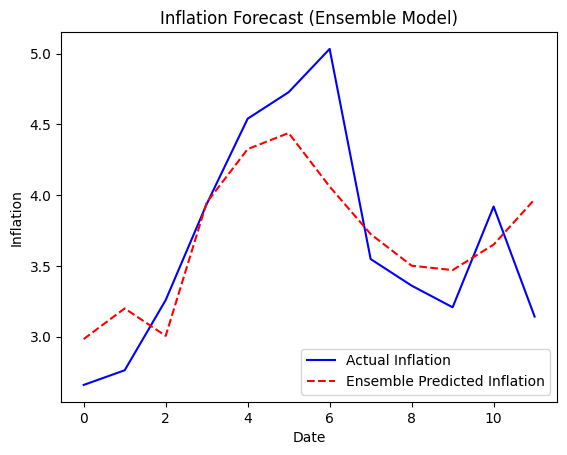

In [169]:
# Plot actual vs predicted inflation for the ensemble model
plt.plot(y_test.index, y_test, label='Actual Inflation', color='blue')
plt.plot(y_test.index, final_ensemble_pred, label='Ensemble Predicted Inflation', linestyle='--', color='red')
plt.legend()
plt.title("Inflation Forecast (Ensemble Model)")
plt.xlabel("Date")
plt.ylabel("Inflation")
plt.show()

In [170]:
# Flatten y_test and final_ensemble_pred to make them 1-dimensional
y_test_flat = y_test.values.ravel()  # Convert y_test to a 1D array
y_pred_ensemble_flat = final_ensemble_pred.ravel()  # Convert ensemble predictions to a 1D array

# Create a DataFrame with Actual vs Predicted Inflation for the ensemble model
inflation_comparison_ensemble = pd.DataFrame({
    'Actual Inflation': y_test_flat,
    'Ensemble Predicted Inflation': y_pred_ensemble_flat
})

# Display the table
print(inflation_comparison_ensemble)

# Optionally, save it to a CSV file
inflation_comparison_ensemble.to_csv('inflation_comparison_ensemble.csv', index=False)


    Actual Inflation  Ensemble Predicted Inflation
0           2.659581                      2.983712
1           2.763105                      3.200124
2           3.258886                      3.006111
3           3.936922                      3.947911
4           4.540525                      4.325689
5           4.727825                      4.439273
6           5.033436                      4.060910
7           3.548792                      3.725445
8           3.360973                      3.502007
9           3.208128                      3.470916
10          3.920039                      3.650754
11          3.142613                      3.970686
